# Requirement 2: Multiple products and stochastic environment


This notebook was developed by:
- Carminati Gabriele
- Compagnoni Riccardo Domingo
- De Introna Federico
- Di Giore Francesco
- Fossa' Chiara

The aim of this notebook is to analyze how well a Combinatorial UCB agent performs in a dynamic pricing scenario, with:
- multiple types of products to sell.
- only one customer at each round.
- with a budget constraint on the global units of products sold.
- the seller can sell multiple products at each round.

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.special import expit, logit
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import multiprocessing as mp
from threading import Thread
from math import erf

c:\Users\digio\OneDrive\Documents\Francesco\Universita\Secondo Anno Magistrale\Online Learning Applications\Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Definition of the Environment

We define an environment with multiple products, where customer preferences are modeled by **joint valuations**.  
Specifically, valuations follow a **multivariate logit-normal distribution**.  

- The latent Gaussian parameters $(\mu, \Sigma)$ are approximated using the **delta method**, given the desired mean and covariance in valuation space.  
- For each round, product valuations are sampled by drawing from the latent multivariate normal and applying the **sigmoid transformation** to map values into $[0,1]$.  
- A purchase occurs if a product’s valuation exceeds its price, and the purchase probability can be computed directly from the latent distribution.  


In [ ]:
class MultiProductPricingEnvironment:
    """
    Environment for simulating multi-product pricing under logit-normal valuations.
    Each product has a latent valuation distribution, and sales occur if valuation >= price.
    """
    def __init__(self, products,
                 means,
                 covs,
                 seed=42,
                 plot_distribution=True,
                 T=None):
        self.products = products
        self.d = len(products)
        self.means, self.covs = self.delta_method_latent_from_logitnormal(means, covs)
        self.rng = np.random.default_rng(seed)
        self.cached_valuations = False
        # Optional visualization of the distribution of valuations
        if plot_distribution:
            n_samples = 100_000
            bins=100
            samples = self.sample_valuations(n_samples)
            for i, product in enumerate(products):
                plt.figure(figsize=(7, 3))
                plt.hist(samples[:, i], bins=bins, density=True)
                plt.title(f"Distribution of valuations for product {product} (100000 rounds)")
                plt.xlabel("valuation")
                plt.ylabel("density")
                plt.xlim(0, 1)
                plt.tight_layout()
                plt.show()
        # If time horizon T is given, pre-sample valuations for speed
        if T is not None:
            self.valuations_samples = self.sample_valuations(T)
            self.cached_valuations = True
            self.i=0

    def compute_Q(self, prices_grid, eps = 1e-12):
        """
        Computes the real probabilities of a product to get sold
        A sale happens if W>=p (W logit-normal distr.), but since sigmoid is monotone it is equivalent to Y>=logit(p) (Y underlying normal)
        """
        # Standard deviations
        dvs = np.sqrt(np.clip(np.diag(self.covs), 0.0, None))
        # Logits of prices
        pc = np.clip(prices_grid, eps, 1 - eps)
        logits = np.log(pc / (1 - pc))
        # Calculations with the underlying normal
        Phi = lambda x: 0.5 * (1.0 + np.vectorize(erf)(x / np.sqrt(2.0)))
        z = (logits[None, :] - self.means[:, None]) / np.where(dvs > 0, dvs, 1.0)[:, None]
        Q = 1.0 - Phi(z)
        # Boundaries
        Q[:, prices_grid <= 0.0] = 1.0
        Q[:, prices_grid >= 1.0] = 0.0
        # If there are determinist prices (zero variance), set the prices above the valuation to 0 and 1 below
        det = dvs == 0.0
        if np.any(det):
            v = 1.0 / (1.0 + np.exp(-self.means[det]))
            Q[det] = (v[:, None] >= prices_grid[None, :]).astype(float)
        return Q

    @staticmethod
    def delta_method_latent_from_logitnormal(m, C):
        """
        Approximate latent Gaussian parameters (mu, Sigma_Z) for a multivariate logit-normal
        with desired mean vector m in (0,1)^d and covariance C.

        Uses first-order delta method:
            J = diag( m_i * (1 - m_i) )
            Sigma_Z ≈ J^{-1} C J^{-1}
            mu ≈ logit(m)
        """
        m = np.asarray(m, dtype=float)
        C = np.asarray(C, dtype=float)
        mu = logit(m)
        gprime = m * (1.0 - m)  # derivative of expit at mu where expit(mu)=m
        if np.any(gprime <= 0):
            raise ValueError("Means too close to 0 or 1 make the delta method unstable.")
        Jinv = np.diag(1.0 / gprime)
        Sigma_Z = Jinv @ C @ Jinv
        # Symmetrize small numerical asymmetry
        Sigma_Z = 0.5 * (Sigma_Z + Sigma_Z.T)
        return mu, Sigma_Z

    def sample_valuations(self, n=1):
        """
        Sample product valuations (in [0,1]) from the logit-normal distribution.
        If caching is enabled, return pre-sampled valuations sequentially.
        """
        if self.cached_valuations:
            self.i+=1
            return self.valuations_samples[self.i-1]
        # Sample latent Gaussian values
        z = self.rng.multivariate_normal(self.means, self.covs, size=n)
        # Apply sigmoid to get valuations in [0,1]
        if n==1:
            return expit(z).ravel()
        return expit(z)

    def round(self, chosen_prices):
        """
        Simulate one round of interaction with the environment:
        - Sample valuations
        - Determine which products are sold (valuation >= price)
        - Compute reward = price * sold (revenue per product)
        """
        vals = self.sample_valuations()
        sold = (vals >= chosen_prices).astype(int)
        reward = np.multiply(chosen_prices, sold)
        return sold, reward

### Definition of the Agent: Combinatorial UCB paired with Gaussian Processes

The agent is a combination of Combinatorial UCB and Gaussian Processes (GP).
It models the demand curve of each product using a **Gaussian Process (GP) with an RBF kernel**, providing both posterior mean $\mu(x)$ and uncertainty $\sigma(x)$ for each candidate price $x$.
At each round $t$, the agent:

1. **Estimates demand**  
   For each product-price pair, it computes  
   - Upper confidence bound (UCB):  
     $$
     r^{\text{ucb}}(x) = \big(\mu(x) + \beta_t \, \sigma(x)\big) \cdot x
     $$
   - Lower confidence bound (LCB):  
     $$
     c^{\text{lcb}}(x) = \max\big(\mu(x) - \beta_t \, \sigma(x), \, \varepsilon\big)
     $$

2. **Optimizes pricing under budget**  
   Solves a linear program:
   $$
   \max_{x \in \Delta} \; \sum_{i,p} r^{\text{ucb}}_{i,p} \, x_{i,p}
   \quad \text{s.t.} \quad 
   \sum_{i,p} c^{\text{lcb}}_{i,p} \, x_{i,p} \leq \rho_t, \;
   \sum_p x_{i,p} = 1 \; \forall i
   $$
   where $x_{i,p}$ is the choice probability of price $p$ for product $i$,  
   and $\rho_t$ is the per-round budget.

3. **Samples a discrete action** from the optimal fractional solution.  

4. **Updates GP models** with observed sales and adjusts the budget state.

In [ ]:
class RBFGaussianProcess:
    """
    Gaussian Process regressor with an RBF kernel.
    Maintains an inverse kernel matrix incrementally for efficiency.
    """
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale  # Kernel scale: controls smoothness of GP
        self.reg = reg    # Regularization (numerical stability)
        self.k_xx_inv = None    # Cached inverse kernel matrix (for incremental updates)

    def rbf_kernel_incr_inv(self, B, C, D):
        """
        Incrementally update the inverse of the kernel matrix
        using block-matrix inversion formula.

        Parameters:
        - B, C, D: submatrices from kernel expansion
        """
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        # Block matrix inversion
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        # Rebuild new inverse kernel matrix
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        """
        RBF (Gaussian) kernel function.

        k(x, x') = exp(-scale * ||x - x'||^2)

        The inputs are reshaped into column vectors to allow broadcasting.
        """
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)

    def fit(self, x=np.array([]), y=np.array([])):
        """
        Fits the GP incrementally with a new observation (x, y).
        - If: first call: build kernel matrix from scratch.
        - Otherwise: update inverse kernel matrix incrementally.
        """
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            # First datapoint: initialize GP
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            # Kernel matrix + regularization
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            # Updates GP with new observation
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            # Uses block matrix inversion for efficiency
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        """
        Predict GP posterior mean and variance at new input points.
        Returns:
        - mu_hat: mean prediction
        - sigma_hat: variance estimate (uncertainty)
        """
        k = self.rbf_kernel(x_predict, self.x)
        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)
        return mu_hat.ravel(), sigma_hat.ravel()

In [ ]:
class OptimisticBandit:
    """
    Agent implementing Combinatorial UCB with Gaussian Processes
    for multi-product pricing under budget constraints.
    """
    def __init__(self, products, prices, budget, T, seed=42):
        self.T = T
        self.prices = prices
        # Scale is particularly important: it determines how much a point's update affects the points around it.
        # The higher the scale the more point-wise the gp is, the lower the smoother
        self.gps = [RBFGaussianProcess(scale=30).fit() for _ in range(len(products))]
        # Current action (chosen prices per product)
        self.a_t = np.zeros(len(products))
        self.a_t_indices = np.zeros(len(products), dtype=int)
        # GP posterior estimates at each iteration
        self.mu_ts = np.zeros((len(products), len(prices)))
        self.sigma_ts = np.zeros((len(products), len(prices)))
        # Exploration parameters
        self.gamma = lambda t: np.log(t+1)**2
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(self.T)))
        self.N_pulls = np.zeros((len(products), len(prices)))
         # Budget management
        self.t = 1
        self.products = products
        self.rho_t = budget/T
        self.rhos = [self.rho_t]
        self.lr = 0.1
        self.rem_budget = budget
        self.idxs_by_product = {pr: i*len(prices) + np.arange(len(prices)) for i, pr in enumerate(self.products)}
        self.n_arms = len(prices)*len(products)
        self.rng = np.random.default_rng(seed)
        self.r_ucbs = []
        self.c_lcbs = []

    def plot_rhos(self):
        """Plots evolution of learned per-round budget (rho_t)."""
        plt.figure(figsize=(15, 8))
        plt.plot(np.arange(len(self.rhos)), self.rhos[:len(self.rhos)])
        initial_value = self.rhos[0]
        plt.axline((0, initial_value), (1, initial_value), linewidth=4, color='r')
        plt.title("Agent's learnt rhos")
        plt.show()

    def amplify_bound(self, sigma):
        # Sigmas are between 0. and 1. so sqrt increases especially the values of sigmas close to 0.
        #return sigma
        return np.power(sigma, 0.5)
    
    def play(self):
        """
        Selects action (prices for all products):
        - Computes UCB/LCB for each (product, price).
        - Solves optimization problem: maximize expected revenue under budget constraint.
        - Samples an action according to optimal fractional solution.
        """
        ucbs = np.zeros(len(self.products)*len(self.prices))
        lcbs = np.zeros(len(self.products)*len(self.prices))
        # GP predictions for each product
        for i, (p, idxs) in enumerate(self.idxs_by_product.items()):
            self.mu_ts[i], self.sigma_ts[i] = self.gps[i].predict(self.prices)
            lcbs[idxs] = self.mu_ts[i] - self.beta(self.t) * self.sigma_ts[i]
            c_ucb = self.mu_ts[i] + self.beta(self.t) * self.amplify_bound(self.sigma_ts[i])
            ucbs[idxs] = c_ucb*self.prices

        lcbs = np.clip(lcbs, 0.005, 1.)
        self.r_ucbs.append(ucbs)
        self.c_lcbs.append(lcbs)
        #  Optimization problem
        x = cp.Variable(self.n_arms)
        obj = cp.Maximize(ucbs @ x)
        constraints = [
            lcbs @ x <= self.rho_t,
            x >= 0,
        ]
        # Each product: choose at most one price
        for p, idxs in self.idxs_by_product.items():
            constraints.append(cp.sum(x[idxs]) == 1)
        # Default case
        xv = np.zeros(self.n_arms)
        for _, idxs in self.idxs_by_product.items():
            xv[idxs[-1]] = 1.0
        try:
            prob = cp.Problem(obj, constraints)
            prob.solve(solver=cp.CLARABEL)
        except Exception as e:
            print(e)
        if x.value is not None:
            xv = np.asarray(x.value).ravel()
            # For some reason it sometimes happens that some values are greater than 1.
            xv = np.clip(xv, 0., 1.)

        # Build action: sample from xv:
        # Sample discrete action from fractional solution
        for i, (p, idxs) in enumerate(self.idxs_by_product.items()):
            sum_x = np.sum(xv[idxs])
            normalized_p = xv[idxs]/sum_x
            k = self.rng.choice(idxs, p=normalized_p)
            idx = int(k%len(self.prices))
            self.a_t[i] = float(self.prices[idx])
            self.a_t_indices[i] = idx

        return self.a_t.copy()

    def plot_ucbs(self, extensive=False):
        """
        Plots UCBs and LCBs across iterations for diagnostics.
        If extensive=True: show time-series per arm.
        Otherwise: only last-step curves.
        """
        R = np.asarray(self.r_ucbs)   # (t, A)
        C = np.asarray(self.c_lcbs)   # (t, A)
        t = np.arange(1, R.shape[0] + 1)
        if extensive:
            for i, p in enumerate(self.products):
                for k, pr in enumerate(self.prices):
                    k = i*len(self.prices) + k
                    fig, ax = plt.subplots(figsize=(7, 3))
                    ax.plot(t, R[:, k], label="r_ucb")
                    ax.plot(t, C[:, k], label="c_lcb")
                    ax.set_title(f"{p} @ {pr:g}")
                    ax.set_xlabel("time")
                    ax.set_ylabel("value")
                    ax.legend()
                    ax.grid(alpha=0.3)
                    plt.show()

        last_C = C[-1]  # (A,)
        for prod in self.products:
            idxs = self.idxs_by_product[prod]
            x = self.prices  # prices for this product
            y = last_C[idxs]              # last c_lcb for those arms
            order = np.argsort(x)
            x, y = x[order], y[order]
            fig, ax = plt.subplots(figsize=(7, 3))
            ax.plot(x, y, linewidth=1, alpha=0.7)
            ax.scatter(x, y)
            # annotate each point with its y value
            for xi, yi in zip(x, y):
                ax.annotate(f"{yi:.4f}", (xi, yi),
                            textcoords="offset points", xytext=(6, 6), ha="left")
            ax.set_title(f"Last c_lcb by price — {prod}")
            ax.set_xlabel("price")
            ax.set_ylabel("last c_lcb")
            ax.grid(alpha=0.3)
            plt.show()

        last_R = R[-1]  # (A,)
        for prod in self.products:
            idxs = self.idxs_by_product[prod]
            x = self.prices   # prices for this product
            y = last_R[idxs]              # last c_lcb for those arms
            order = np.argsort(x)
            x, y = x[order], y[order]
            fig, ax = plt.subplots(figsize=(7, 3))
            ax.plot(x, y, linewidth=1, alpha=0.7)
            ax.scatter(x, y)
            # annotate each point with its y value
            for xi, yi in zip(x, y):
                ax.annotate(f"{yi:.4f}", (xi, yi),
                            textcoords="offset points", xytext=(6, 6), ha="left")
            ax.set_title(f"Last r_lcb by price — {prod}")
            ax.set_xlabel("price")
            ax.set_ylabel("last r_lcb")
            ax.grid(alpha=0.3)
            plt.show()

    def update(self, sold, ):
        """
        Updates GP models with feedback:
        - Adds new observation (price, sold) per product.
        - Updates budget state (remaining budget and rho_t).
        """
        self.N_pulls[np.arange(len(self.products)), self.a_t_indices] += 1
        # Update GP per product with observed demand
        self.gps = [self.gps[i].fit(self.prices[self.a_t_indices[i]], sold[i]) for i in range(len(sold))]
        self.t += 1
        # Budget update
        tot_sold = np.sum(sold)
        self.rem_budget -= tot_sold
        self.rho_t = self.rho_t + self.lr*(self.rhos[0]-tot_sold)
        self.rhos.append(self.rho_t)

### Baseline

The baseline for the problem is the expected utility when the purchasing probabilities of each product are known. It solves the following LP:

\begin{align*}
\max_{X} \quad & \sum_{i=1}^{N} \sum_{j=1}^{K} q_i(p_j) \, p_j \, X_{i,j} \\
\text{s.t.} \quad & \sum_{i=1}^{N} \sum_{j=1}^{K} q_i(p_j) \, X_{i,j} \leq \rho \\
& \sum_{j=1}^{K} X_{i,j} = 1 \quad \forall i = 1, \dots, N \\
& X_{i,j} \ge 0
\end{align*}
where:
- **$X_{i,j}$** (`X[i,j]`):  Fractional probability of selecting price \(p_j\) for product \(i\)
- **$p_{j}$** (`price_grid[j]`):  Candidate price for the \(j\)-th price level.
- **$q_{i}(p_{j})$** (`q_matrix[i,j]`):  Probability that product \(i\) is purchased at price \(p_j\).
- **$\rho$** (`rho`):  Maximum expected units that can be sold in a round (budget/pacing constraint).


In [ ]:
def compute_clairvoyant(price_grid, q_matrix, rho):
    """
    price_grid : shape (K,)
    q_matrix   : shape (N, K)  -> buy probabilities q_i(p_j)
    rho        : expected-units pace for the round

    Returns:
      x_opt : shape (N, K) probabilities for each of N products over K prices
      obj   : optimal expected profit per round
      used_units : sum q_i(p_j) * x_opt[i,j]
    """
    N, K = q_matrix.shape
    P = np.asarray(price_grid, dtype=float)
    V = q_matrix * P[None, :]              # expected profit per (i,j)
    r = V.reshape(-1)                      # objective coefficients
    c = q_matrix.reshape(-1)               # units coefficients
    n_atoms = N * K

    x = cp.Variable(n_atoms)
    obj = cp.Maximize(r @ x)
    constraints = [
        c @ x <= float(rho),
        x >= 0,
    ]
    # Each product: sum over its K prices equals 1 (mirrors your agent’s loop)
    for i in range(N):
        idxs = slice(i * K, (i + 1) * K)
        constraints.append(cp.sum(x[idxs]) == 1)
    # Solve convex optimization
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.CLARABEL)
    # Extract solution (falls back to zeros if solver fails)
    xv = np.asarray(x.value).ravel() if x.value is not None else np.zeros(n_atoms)
    xv = np.clip(xv, 0.0, 1.0)
    X = xv.reshape(N, K)
    obj_val = float(prob.value) if prob.value is not None else 0.0
    used_units = float(np.sum(q_matrix * X))
    return X, obj_val, used_units

### Parallelization helper functions

The following functions make the interaction between the Agent and the Environment parallelizable, such that we can execute multiple trials at once, instead of executing the trials in a sequential manner.

In [ ]:

def _progress_listener(q, n_trials, leave=False):
    """
    Render one tqdm bar per trial in the main process.
    Workers send ('init', trial_idx, total), ('update', trial_idx, n), ('close', trial_idx, 0).
    """
    bars = {}
    closed = set()
    while len(closed) < n_trials:
        msg = q.get()
        if msg is None:  # termination signal
            break
        kind, trial_idx, val = msg
        if kind == 'init':
            # Create the bar for this trial if not exists
            if trial_idx not in bars:
                bars[trial_idx] = tqdm(total=int(val),
                                       desc=f"Trial {trial_idx+1}",
                                       position=trial_idx,
                                       leave=leave)
        elif kind == 'update':
            if trial_idx in bars:
                bars[trial_idx].update(int(val))
        elif kind == 'close':
            if trial_idx in bars and trial_idx not in closed:
                bars[trial_idx].close()
                closed.add(trial_idx)
    # Ensure all bars are closed
    for tid, bar in bars.items():
        if tid not in closed:
            bar.close()

def _start_progress(n_trials, leave=False):
    """
    Start a dedicated thread for listening to progress updates.
    Returns (queue, thread, manager).
    """
    mgr = mp.Manager()
    q = mgr.Queue()
    th = Thread(target=_progress_listener, args=(q, n_trials, leave), daemon=True)
    th.start()
    return q, th, mgr

def run_all_trials_parallel(seeds, products, prices, budget, T, means, covs, n_jobs=-1, leave=False):
    """
    Run multiple trials of the experiment in parallel.
    Parameters:
    - seeds (list[int]): Random seeds, one per trial.
    - products (list[str]): Product identifiers.
    - prices (array-like): Candidate price grid.
    - budget (int): Total number of units available.
    - T (int): Time horizon (rounds).
    - means, covs (arrays): Parameters of valuation distribution.
    - n_jobs (int): Number of parallel worker processes (-1 = use all cores).

    Returns:
    - all_regrets (list[list[float]]): Regret trajectories (per trial).
    - actions (list[list[np.ndarray]]): Actions chosen (per trial, per round).
    """
    progress_q, progress_thread, mgr = _start_progress(len(seeds), leave=leave)
    try:
        results = Parallel(n_jobs=n_jobs, prefer="processes")(
            delayed(run_single_trial)(
                trial_idx, products, prices, budget, T, means, covs, seed, False, progress_q
            )
            for trial_idx, seed in enumerate(seeds)
        )
    finally:
        # tell listener to exit if not already
        progress_q.put(None)
        progress_thread.join()
        mgr.shutdown()

    all_regrets = [results[i][0] for i in range(len(results))]
    actions = [results[i][1] for i in range(len(results))]
    return all_regrets, actions


def run_single_trial(trial_idx, products, prices_per_product, budget, T, means, covs, seed=42, extensive_plots=False, progress_q=None):
    """
    Runs one experiment trial:
    - Creates environment + agent
    - Runs T rounds (or until budget exhausted)
    - Tracks regret against clairvoyant baseline
    - Collects chosen actions
    """
    if progress_q is not None:
        progress_q.put(('init', trial_idx, T))

    # Initialize environment + agent
    env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, seed=seed, T=T, plot_distribution=False)
    agent = OptimisticBandit(products, prices_per_product, budget, T, seed=seed)
    # Actual probabilities for a product to get sold
    Q = env.compute_Q(prices_per_product)
    _, expected_clairvoyant_utility, _ = compute_clairvoyant(prices_per_product, Q, budget/T)

    cumulative_regret = []
    cum_reg = 0.0
    actions = []
    rhos = []
    rem_bud = budget

    # Simulation loop
    for t in range(1, T + 1):
        if agent.rem_budget <= 0:
            # close early if budget exhausted
            if progress_q is not None:
                progress_q.put(('close', trial_idx, 0))
            break
        # Agent chooses prices
        action = agent.play()
         # Environment returns sales + reward
        sold, reward = env.round(action)
        # Update effective remaining budget pace
        rem_bud -= np.sum(sold)
        rho = rem_bud/(T-t+1)
        rhos.append(rho)
         # Agent updates its model
        agent.update(sold=sold)
        # Compute regret (gap vs clairvoyant)
        cum_reg += expected_clairvoyant_utility - reward.sum()
        cumulative_regret.append(cum_reg)
        actions.append(action)
        if progress_q is not None:
            progress_q.put(('update', trial_idx, 1))
    else:
        # loop ended normally
        if progress_q is not None:
            progress_q.put(('close', trial_idx, 0))

    # Extensive plots plot r and c bounds for each product, price and time instant. Otherwise just last step
    agent.plot_ucbs(extensive=extensive_plots)
    # Agent's learnt rhos
    agent.plot_rhos()
    # Effective rhos, based on remaining budget and time steps
    plt.figure(figsize=(15, 8))
    plt.plot(np.arange(len(rhos)), rhos[:len(rhos)])
    plt.axline((0, rhos[0]), (1, rhos[0]), linewidth=4, color='r')
    plt.title('Effective rhos')
    plt.show()

    return cumulative_regret, actions

# Experiments

Now we do several experiments, changing the parameters of the environment to simulate different conditions for the agent.

### Trial with B >> T and uncorrelated products

We test the Agent when the budget B is way more than the number of rounds T and the products are uncorrelated (no covariance, only variance). So, it can be considered as unconstrained dynamic pricing.

Discretizing prices with 14 values


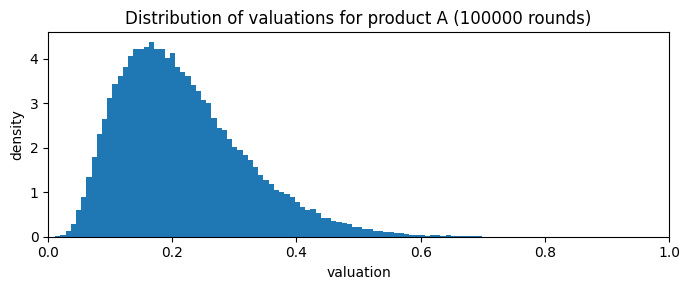

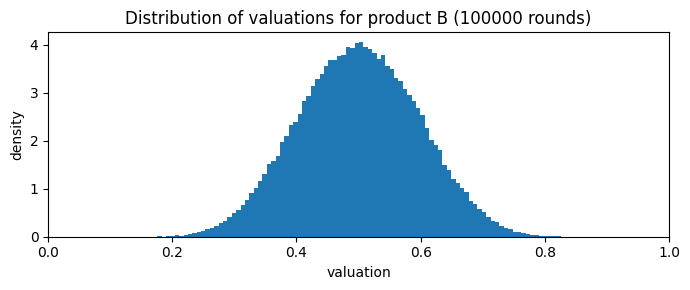

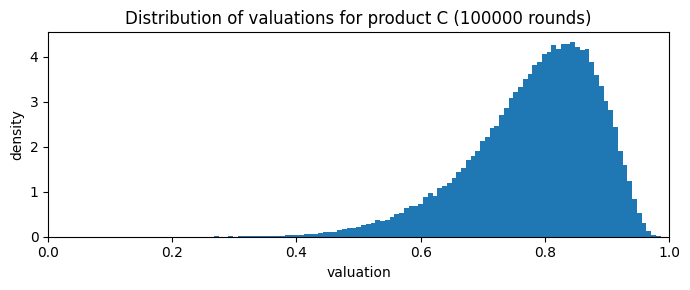

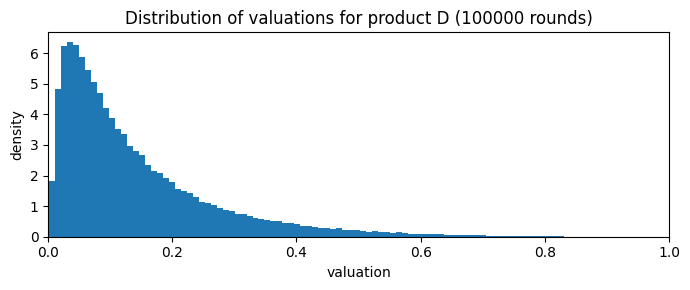

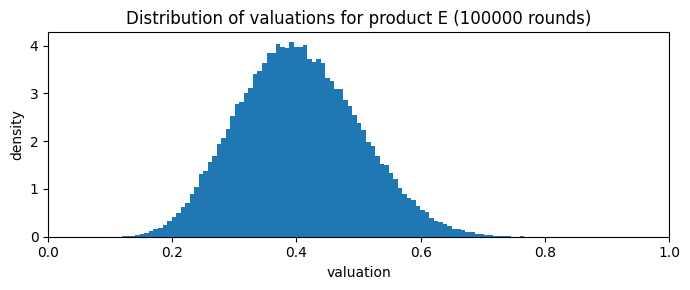

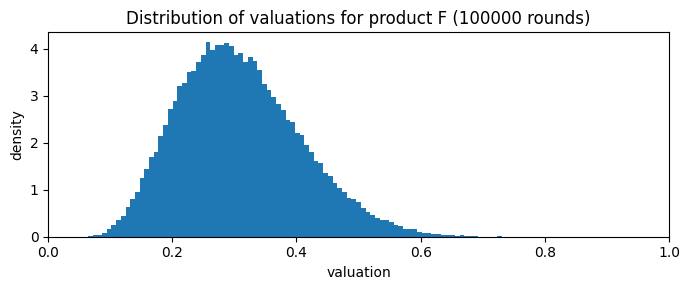

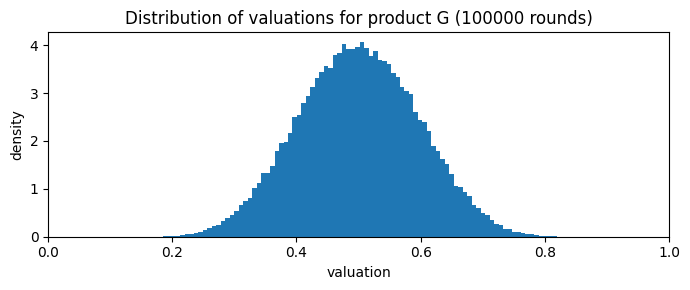


Trial 1:   0%|          | 0/500 [00:00<?, ?it/s]






Trial 1:   0%|          | 2/500 [00:00<00:25, 19.19it/s]






Trial 1:   2%|▏         | 8/500 [00:00<00:12, 39.89it/s]














Trial 1:   3%|▎         | 13/500 [00:00<00:11, 42.43it/s]










Trial 1:   4%|▎         | 18/500 [00:00<00:10, 44.26it/s]














Trial 1:   5%|▍         | 23/500 [00:00<00:11, 41.85it/s]














Trial 1:   6%|▌         | 28/500 [00:00<00:11, 42.37it/s]














Trial 1:   7%|▋         | 33/500 [00:00<00:10, 43.37it/s]














Trial 1:   8%|▊         | 38/500 [00:00<00:10, 44.09it/s]














Trial 1:   9%|▊         | 43/500 [00:01<00:10, 43.95it/s]














Trial 1:  10%|▉         | 48/500 [00:01<00:10, 44.05it/s]




















Trial 1:  11%|█         | 53/500 [00:01<00:10, 43.72it/s]




















Trial 1:  12%|█▏        | 58/500 [00:01<00:10, 42.92it/s]




















Trial 1:  13%|█▎        | 63/500 [00:01<00:13, 32.56it/s]




















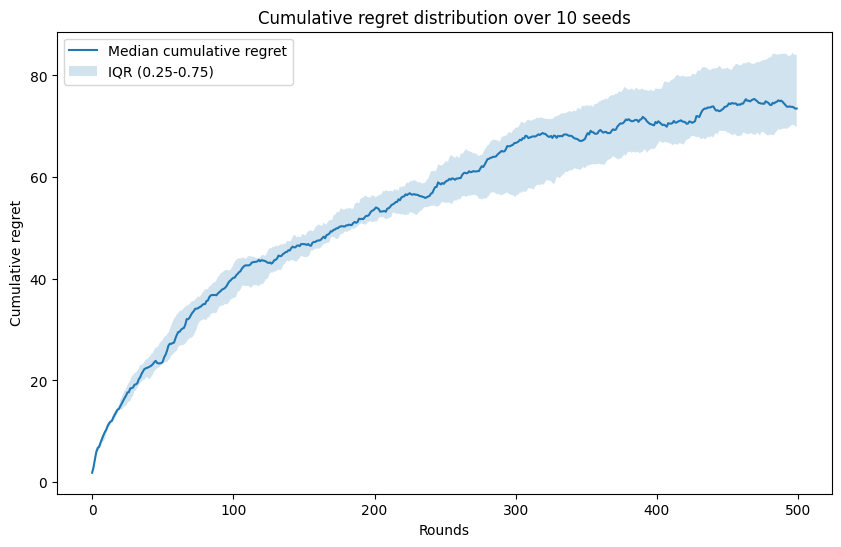

In [ ]:
run_one = False
# product set
products = ['A','B','C', 'D', 'E', 'F', 'G']
budget = 3000
T = 500
seeds = [23424,3431,65762,842357,2346532,13564,98765,2557,123564,12364]
epsilon = T ** (-0.33)
# The two was chosen empirically
K = 2*int(1 / epsilon)
print(f'Discretizing prices with {K} values')
prices_per_product = np.linspace(0, 1, K)
means = np.array([0.2, 0.5, 0.8, 0.1, 0.4, 0.3, 0.5])
vars = 0.01*np.ones(len(products))
covs = 0.*np.min(vars)*np.ones((len(products), len(products)))
np.fill_diagonal(covs, vars)
# Just to plot distribution
env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, plot_distribution=True)
# Runs one trial or multiple trials
if run_one:
    cum_regret, actions = run_single_trial(0, products, prices_per_product, budget, T, means, covs, seed=3, extensive_plots=False)
    median_regret = cum_regret
else:
    all_regrets, actions = run_all_trials_parallel(seeds, products, prices_per_product, budget, T, means, covs, n_jobs=-1)
    # Pads regrets to uniform length
    all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
    # Computes quantiles across trials for regret analysis
    lq_regret, median_regret, hq_regret = np.quantile(all_regrets, q=[0.25, 0.5, 0.75], axis=0)

# Plot cumulative regret
plt.figure(figsize=(10,6))
plt.plot(median_regret, label='Median cumulative regret')
if not run_one:
    # Plot interquartile range 
    plt.fill_between(range(T), lq_regret, hq_regret, alpha=0.2, label='IQR (0.25-0.75)')
plt.xlabel('Rounds')
plt.ylabel('Cumulative regret')
plt.title(f'Cumulative regret distribution over {len(seeds)} seeds')
plt.legend()
plt.show()

We can see that the cumulative regret is **sublinear**, after multiple trials (10 trials).

### Trial with B = T and uncorrelated products

Now, we consider a budget B equal to the number of rounds T. The valuations over the products remain uncorrelated.

Discretizing prices with 14 values


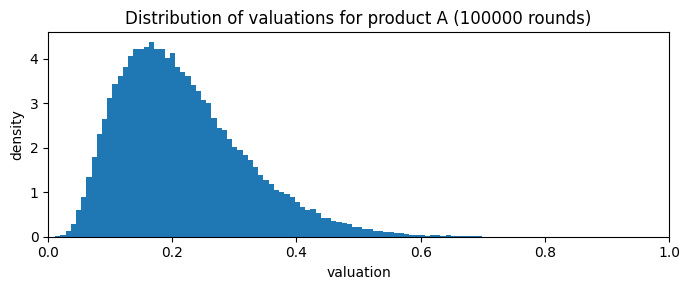

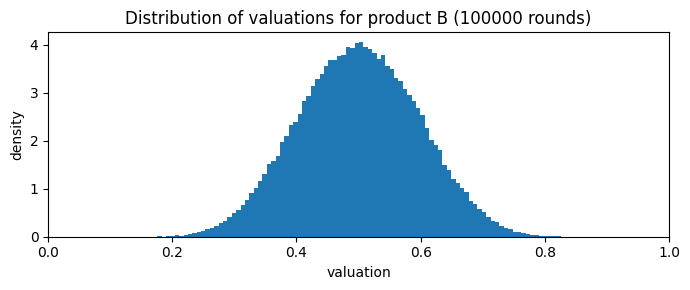

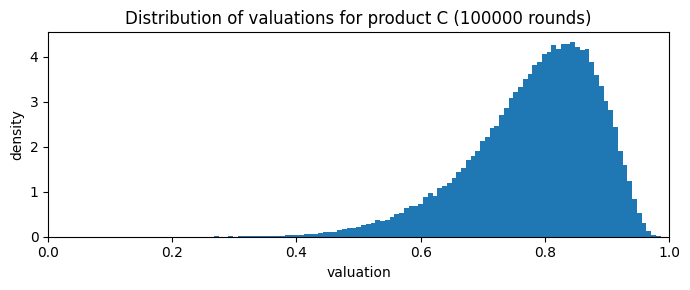

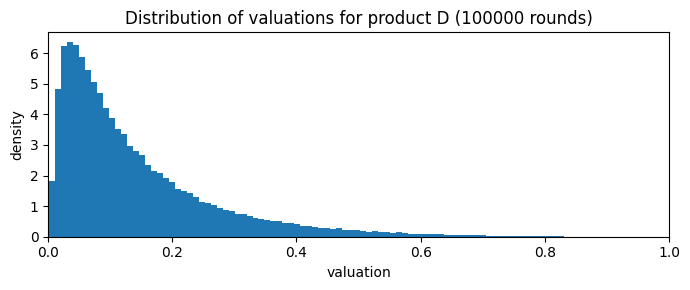

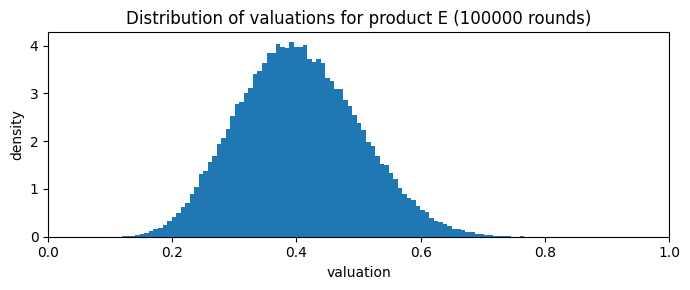

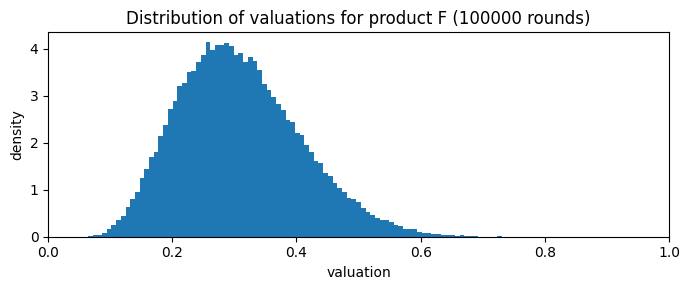

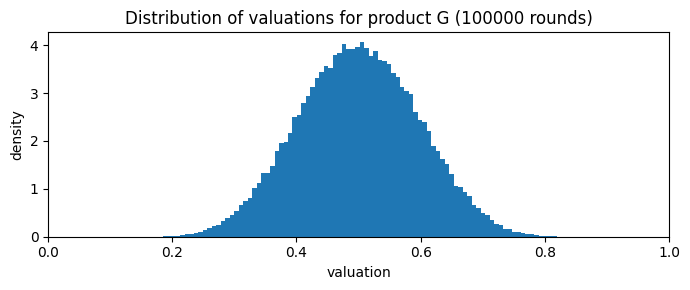

Trial 1:   0%|          | 0/500 [00:00<?, ?it/s]














Trial 1:   1%|          | 5/500 [00:00<00:10, 49.33it/s]












Trial 1:   3%|▎         | 13/500 [00:00<00:08, 60.15it/s]



















Trial 1:   4%|▍         | 19/500 [00:00<00:09, 49.06it/s]




















Trial 1:   5%|▌         | 25/500 [00:00<00:10, 47.05it/s]


















Trial 1:   6%|▌         | 31/500 [00:00<00:09, 48.37it/s]



















Trial 1:   7%|▋         | 36/500 [00:00<00:10, 42.93it/s]

























Trial 1:   8%|▊         | 41/500 [00:00<00:11, 40.10it/s]















Trial 1:   9%|▉         | 46/500 [00:01<00:11, 41.19it/s]










Trial 1:  10%|█         | 51/500 [00:01<00:10, 42.49it/s]














Trial 1:  11%|█         | 56/500 [00:01<00:10, 42.29it/s]




















Trial 1:  12%|█▏        | 61/500 [00:01<00:10, 40.59it/s]




















Trial 1:  13%|█▎        | 66/500 [00:01<00:10, 41.40it/s]

































Trial 1:  14%|█▍ 

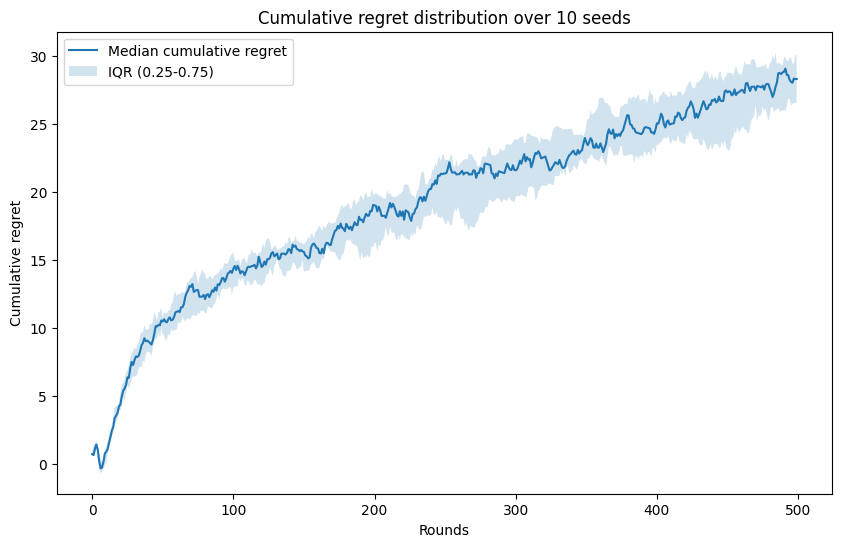

In [ ]:
"""
We study the performance of the Optimistic Bandit agent in a multi-product pricing environment,
under the condition where the total budget (B) equals the time horizon (T). This is a stricter
setting than B >> T, because the agent can only afford on average one unit per round.

Setup:
- 7 products with different mean valuations (0.1–0.8) and small independent variances.
- Products are uncorrelated → covariance matrix is diagonal.
- Price space is discretized into K = 2/ε levels, with ε = T^(-1/3), following a common
  discretization heuristic for bandits.
- We run multiple independent trials (different random seeds) in parallel to estimate the
  distribution of cumulative regret.

Procedure:
- In each trial, the agent interacts with the environment for up to T=500 rounds or until
  the budget is exhausted.
- Cumulative regret is measured against a clairvoyant benchmark that knows the true
  demand probabilities and chooses prices optimally.
- Results are aggregated across seeds, padded to equal length, and summarized using
  the 25%, 50% (median), and 75% quantiles.

Output:
- A plot showing the median cumulative regret over time, with an interquartile range (IQR)
  shaded band across trials. This quantifies both the central tendency and variability of
  the agent's learning performance under the B=T regime.
"""
run_one = False
products = ['A','B','C', 'D', 'E', 'F', 'G']
budget = 500
T = 500
seeds = [23424,3431,65762,842357,2346532,13564,98765,2557,123564,12364]
epsilon = T ** (-0.33)
# The two was chosen empirically
K = 2*int(1 / epsilon)
print(f'Discretizing prices with {K} values')
prices_per_product = np.linspace(0, 1, K)
means = np.array([0.2, 0.5, 0.8, 0.1, 0.4, 0.3, 0.5])
vars = 0.01*np.ones(len(products))
covs = 0.*np.min(vars)*np.ones((len(products), len(products)))
np.fill_diagonal(covs, vars)
# Just to plot distribution
env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, plot_distribution=True)

if run_one:
    cum_regret, actions = run_single_trial(0, products, prices_per_product, budget, T, means, covs, seed=3, extensive_plots=False)
    median_regret = cum_regret
else:
    all_regrets, actions = run_all_trials_parallel(seeds, products, prices_per_product, budget, T, means, covs, n_jobs=-1)
    all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
    lq_regret, median_regret, hq_regret = np.quantile(all_regrets, q=[0.25, 0.5, 0.75], axis=0)

plt.figure(figsize=(10,6))
plt.plot(median_regret, label='Median cumulative regret')
if not run_one:
    plt.fill_between(range(T), lq_regret, hq_regret, alpha=0.2, label='IQR (0.25-0.75)')
plt.xlabel('Rounds')
plt.ylabel('Cumulative regret')
plt.title(f'Cumulative regret distribution over {len(seeds)} seeds')
plt.legend()
plt.show()

Also in this case, the regret appears to be **sublinear**, although a little bit more noisy than the trial before.

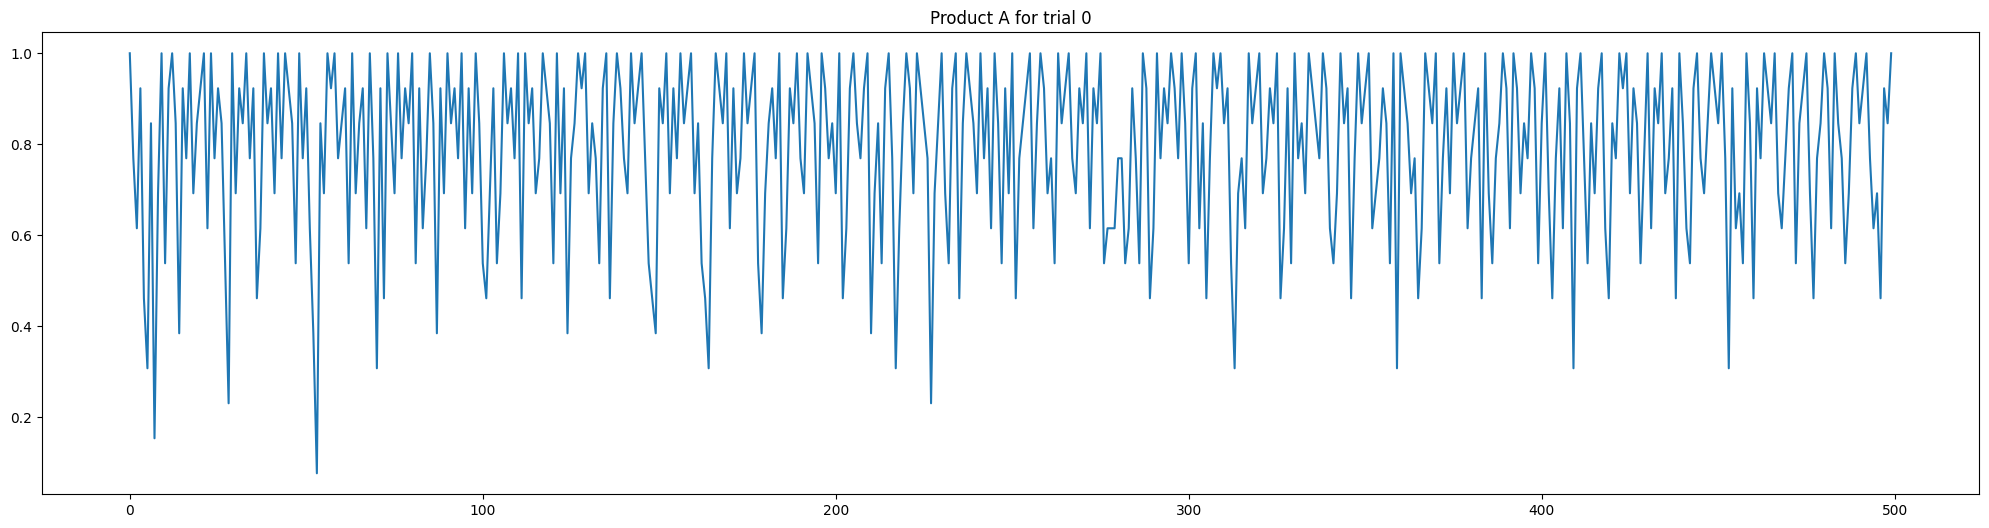

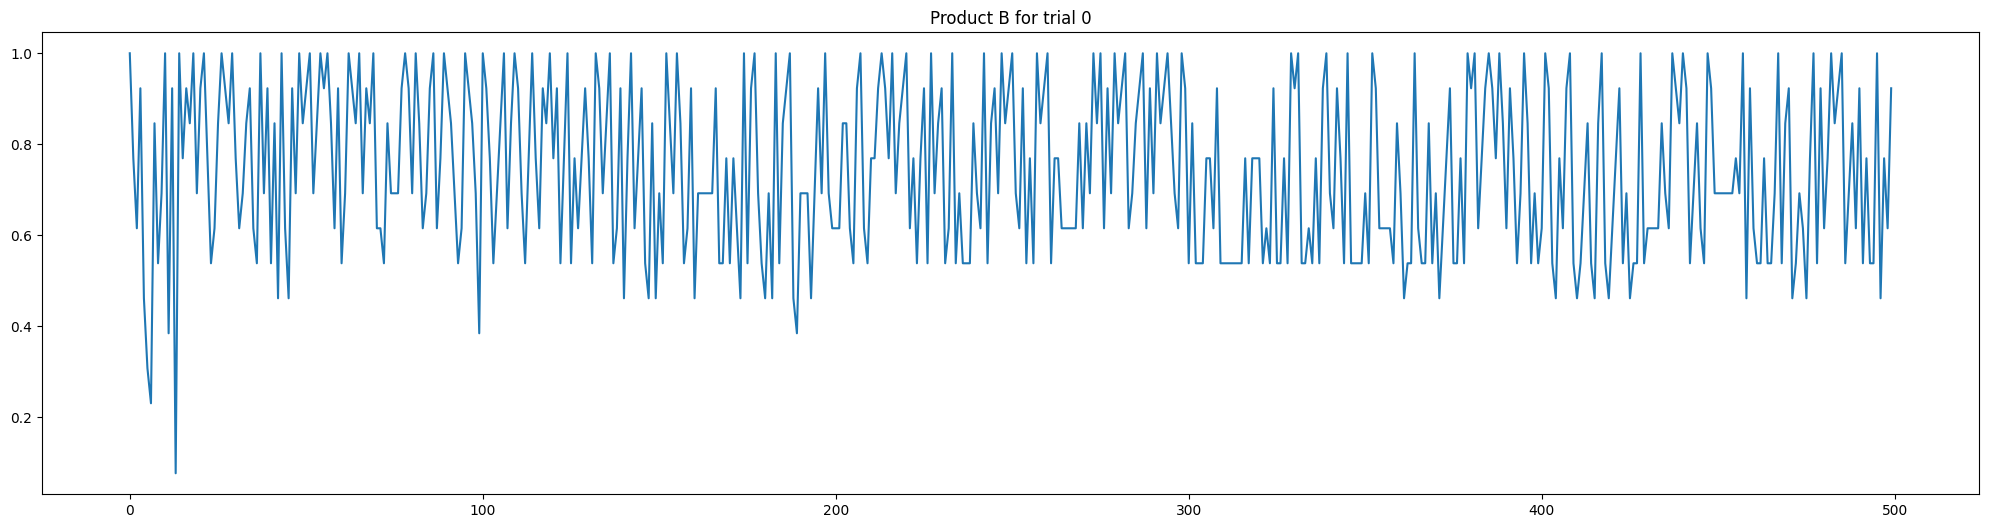

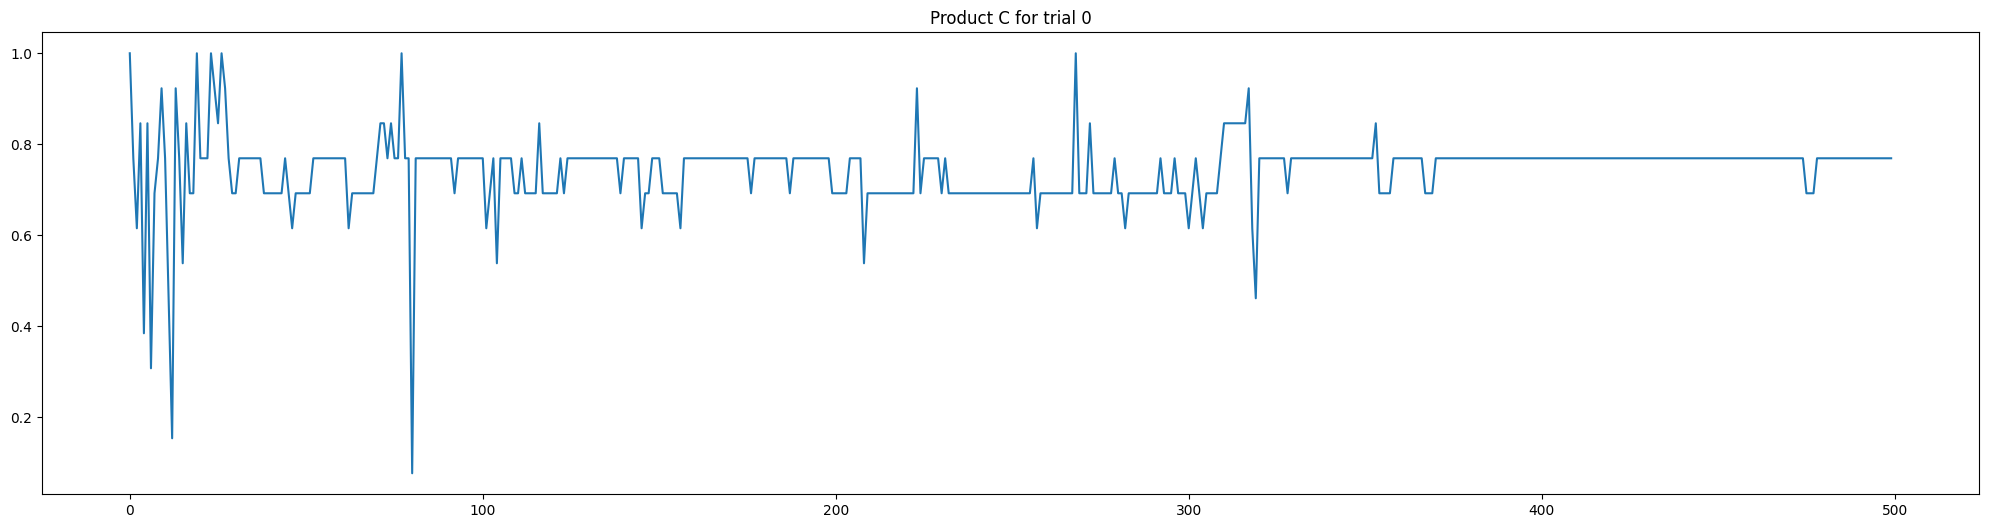

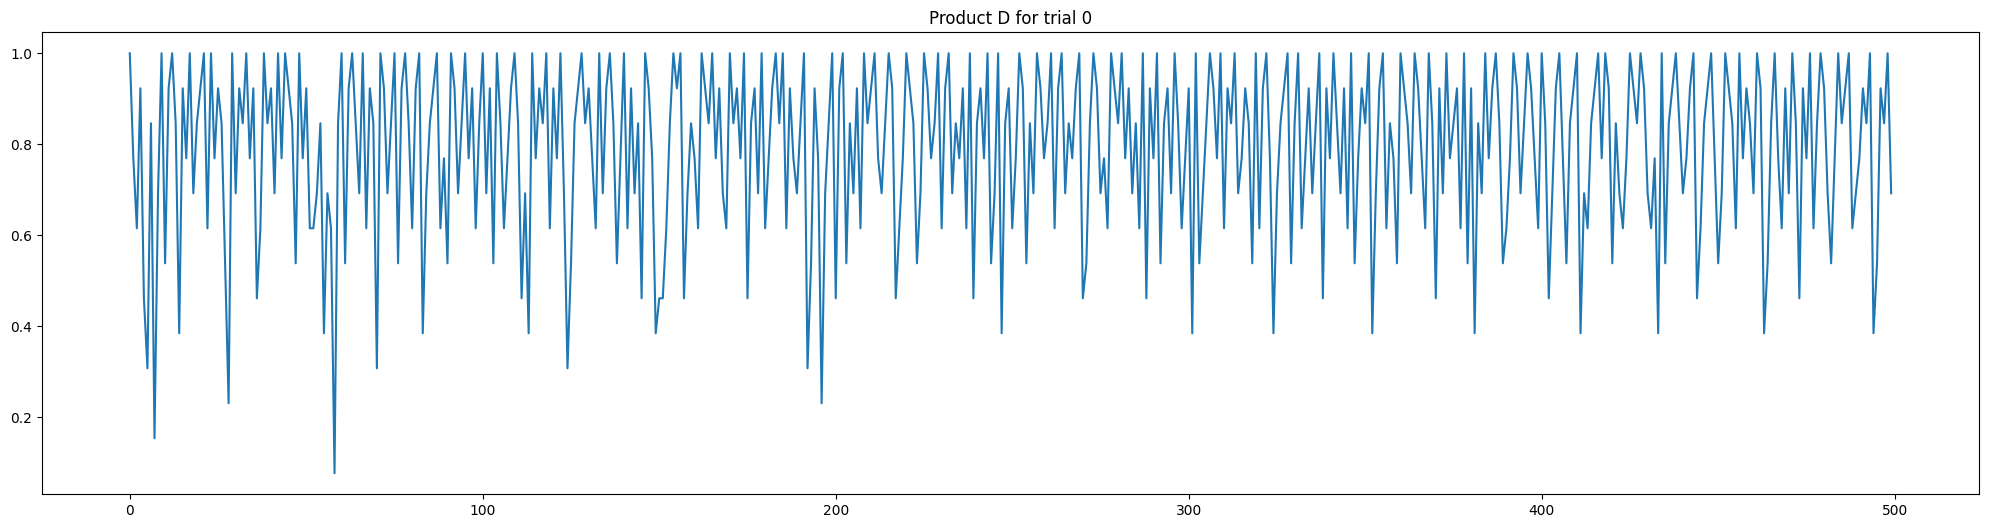

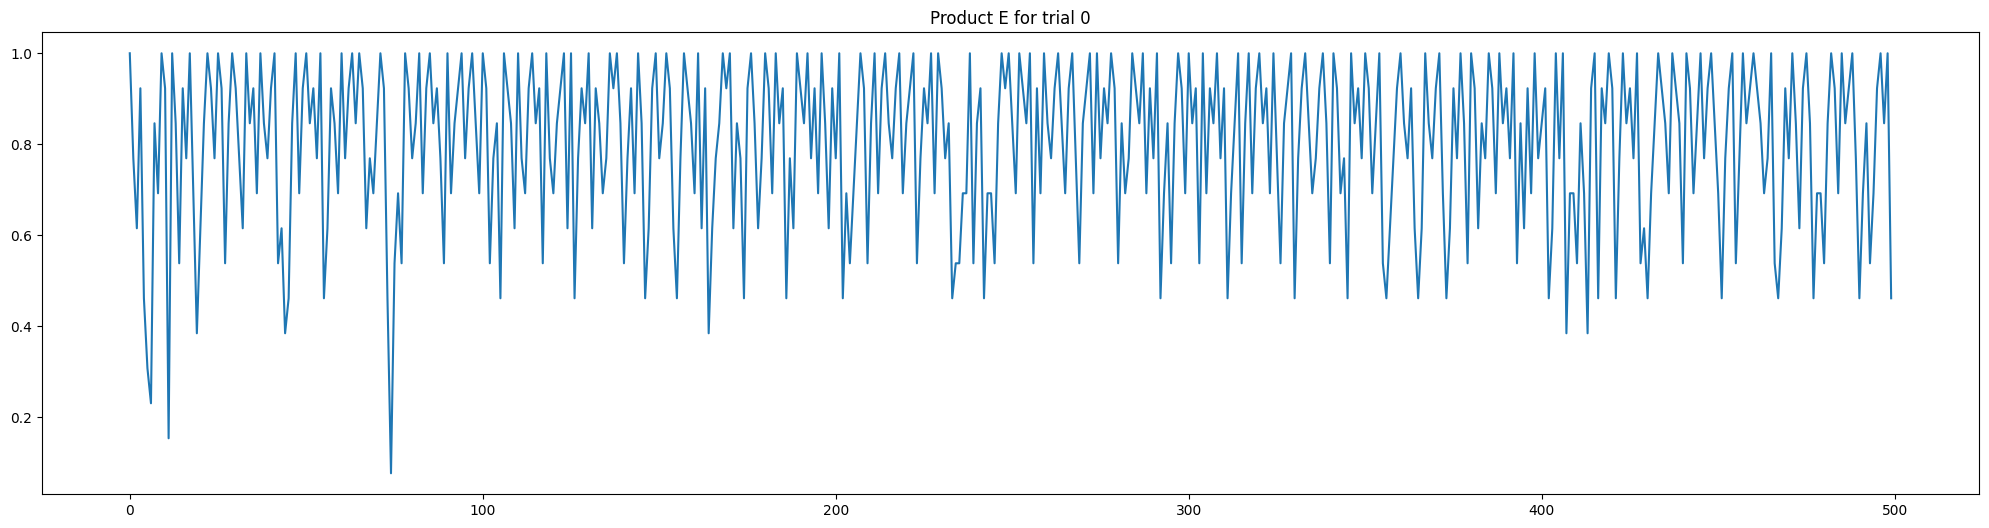

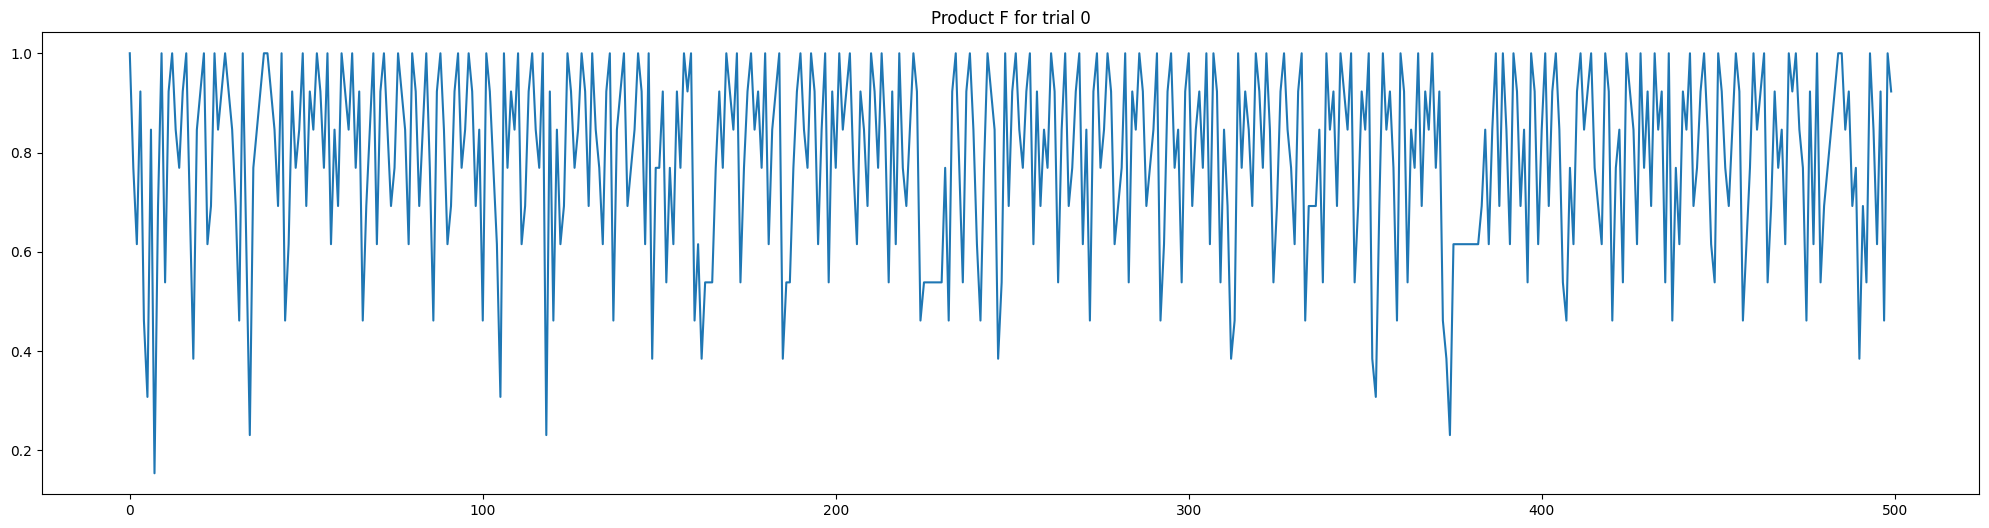

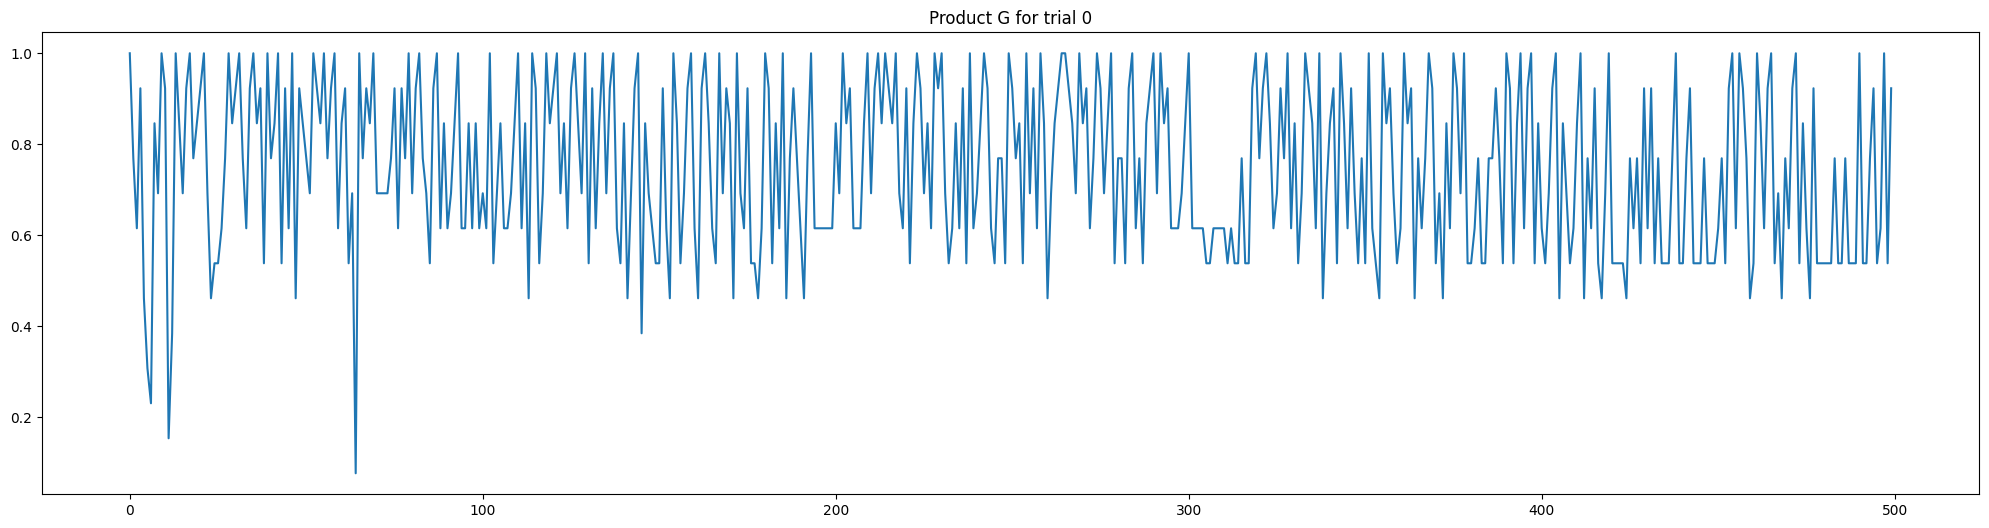

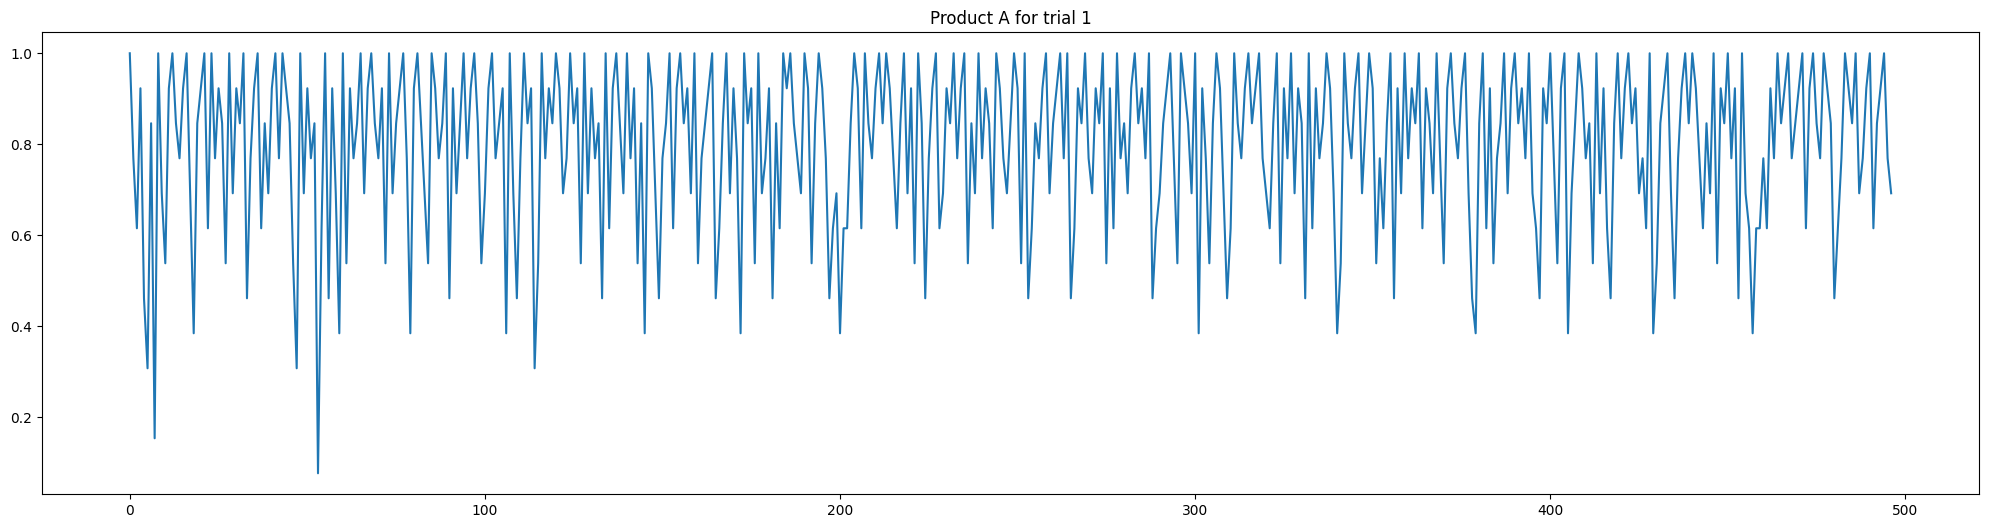

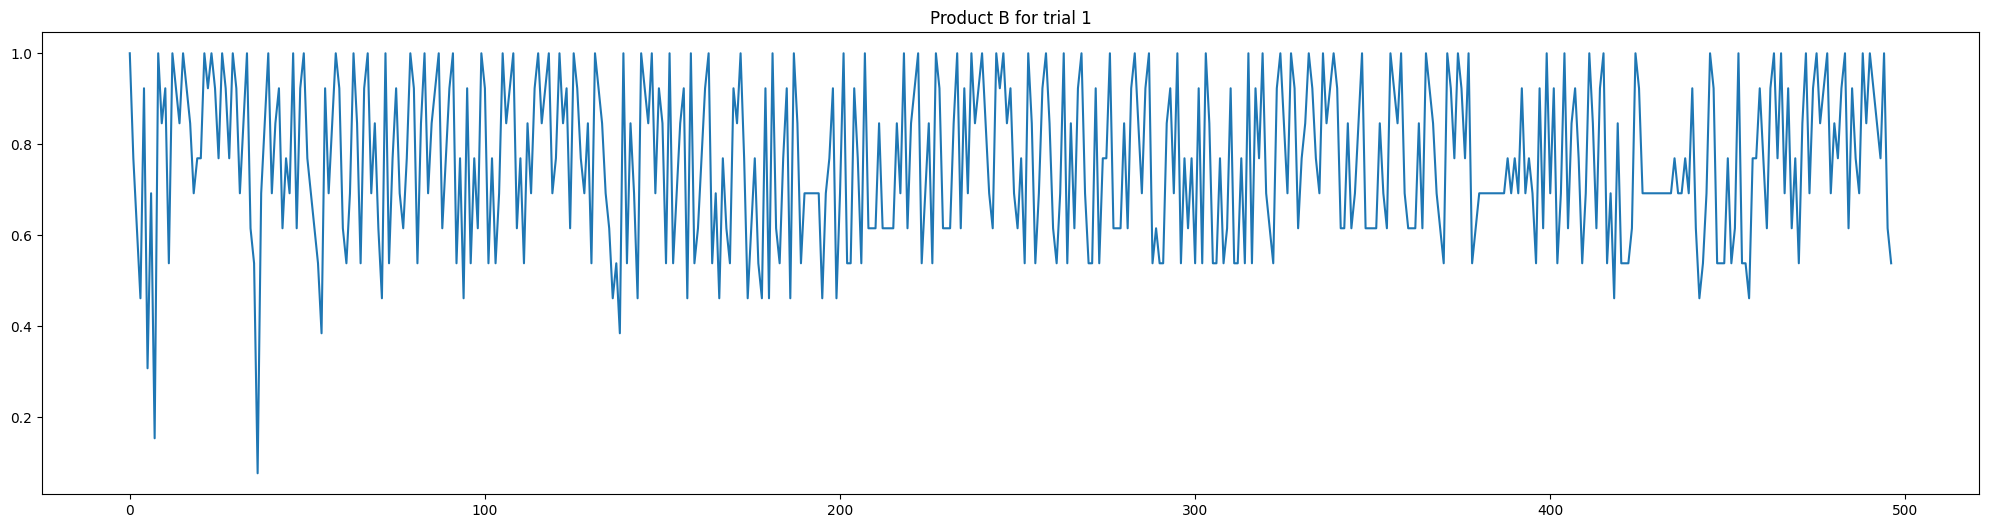

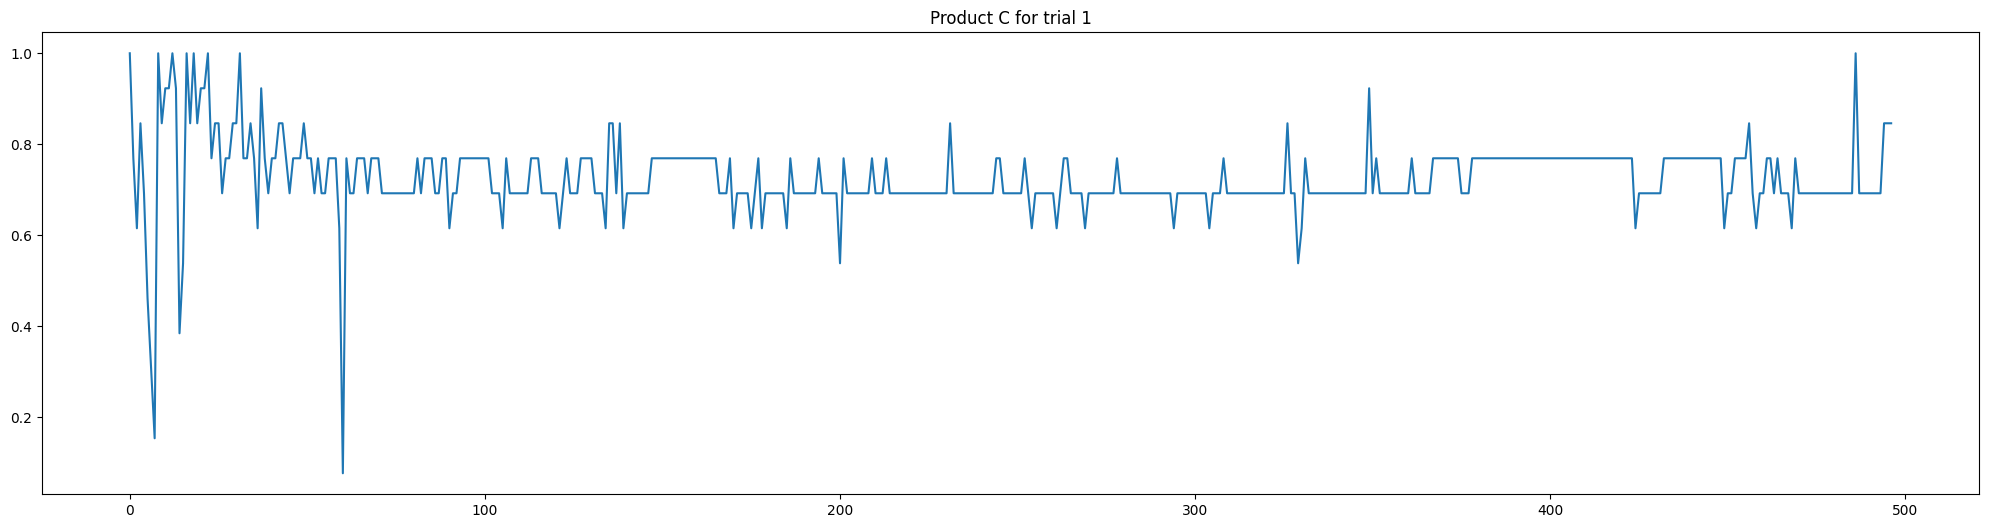

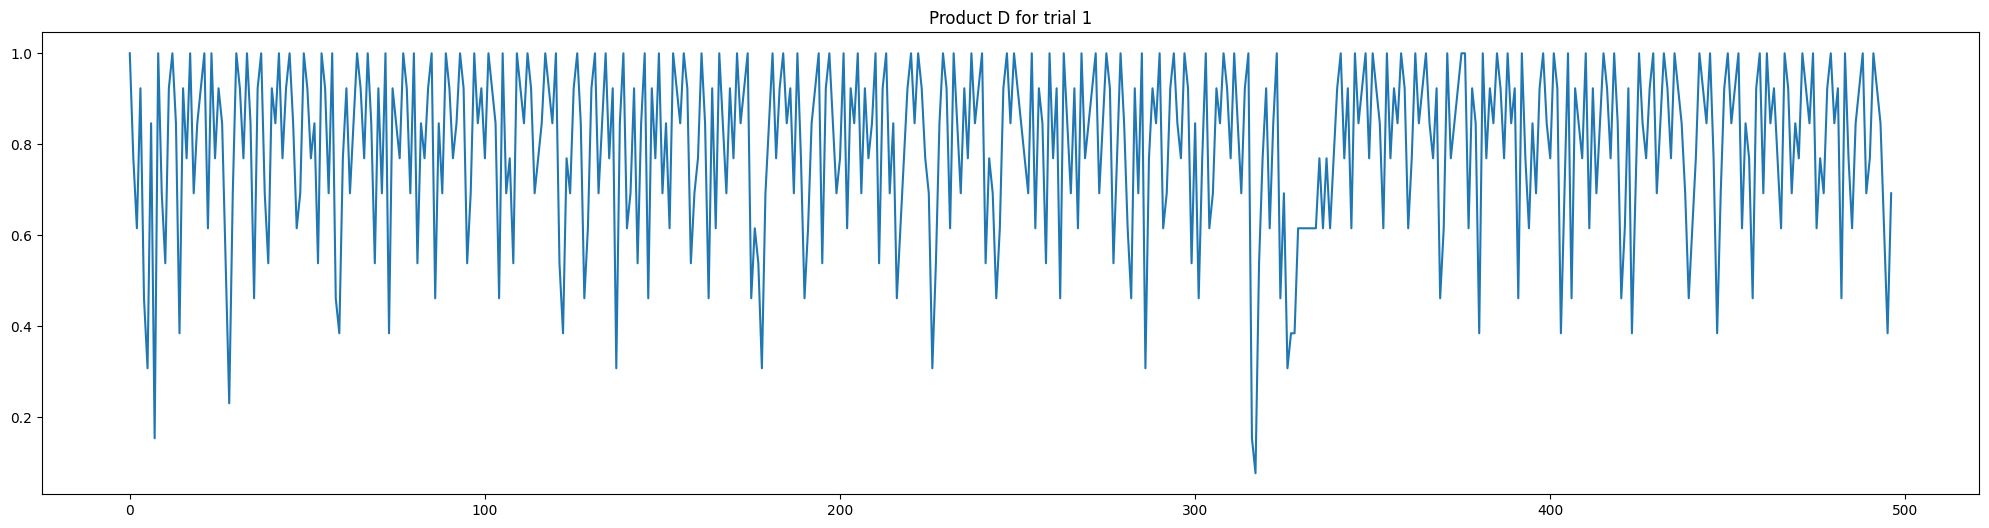

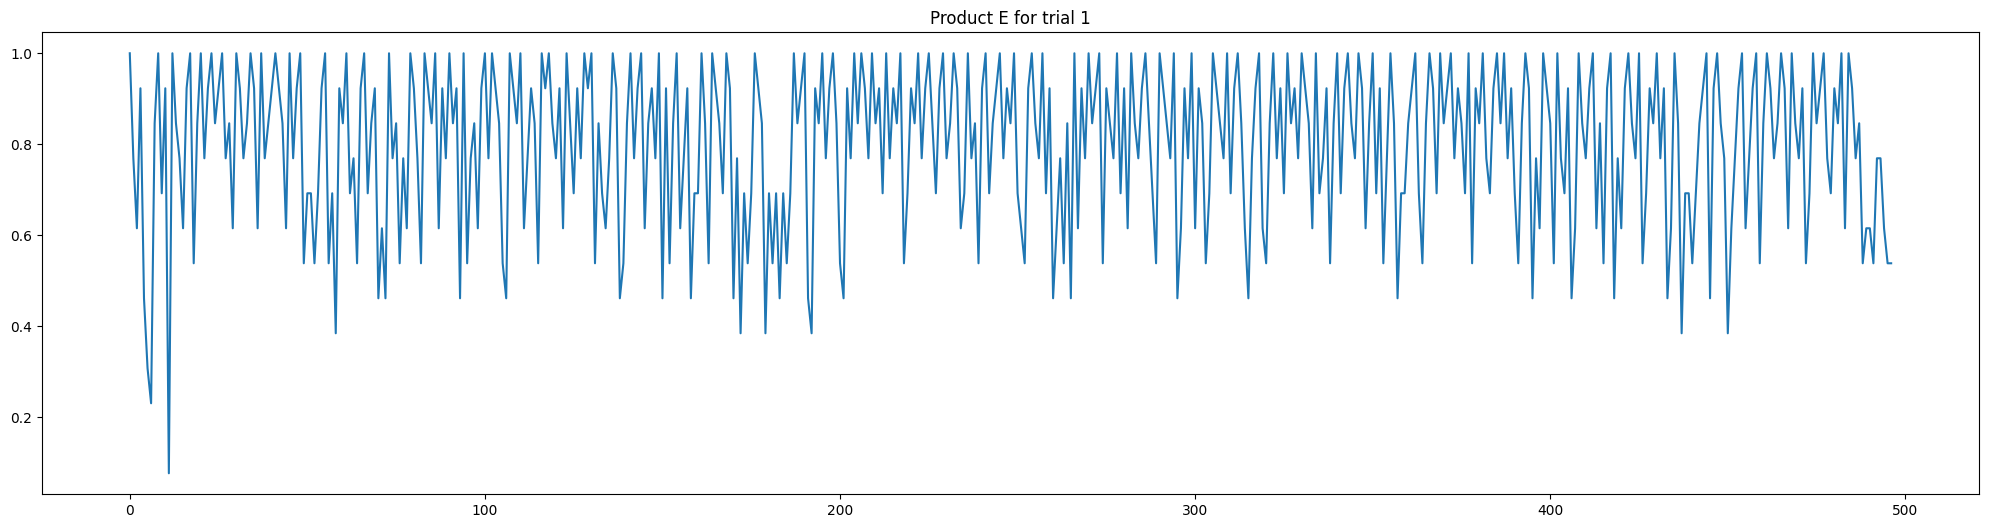

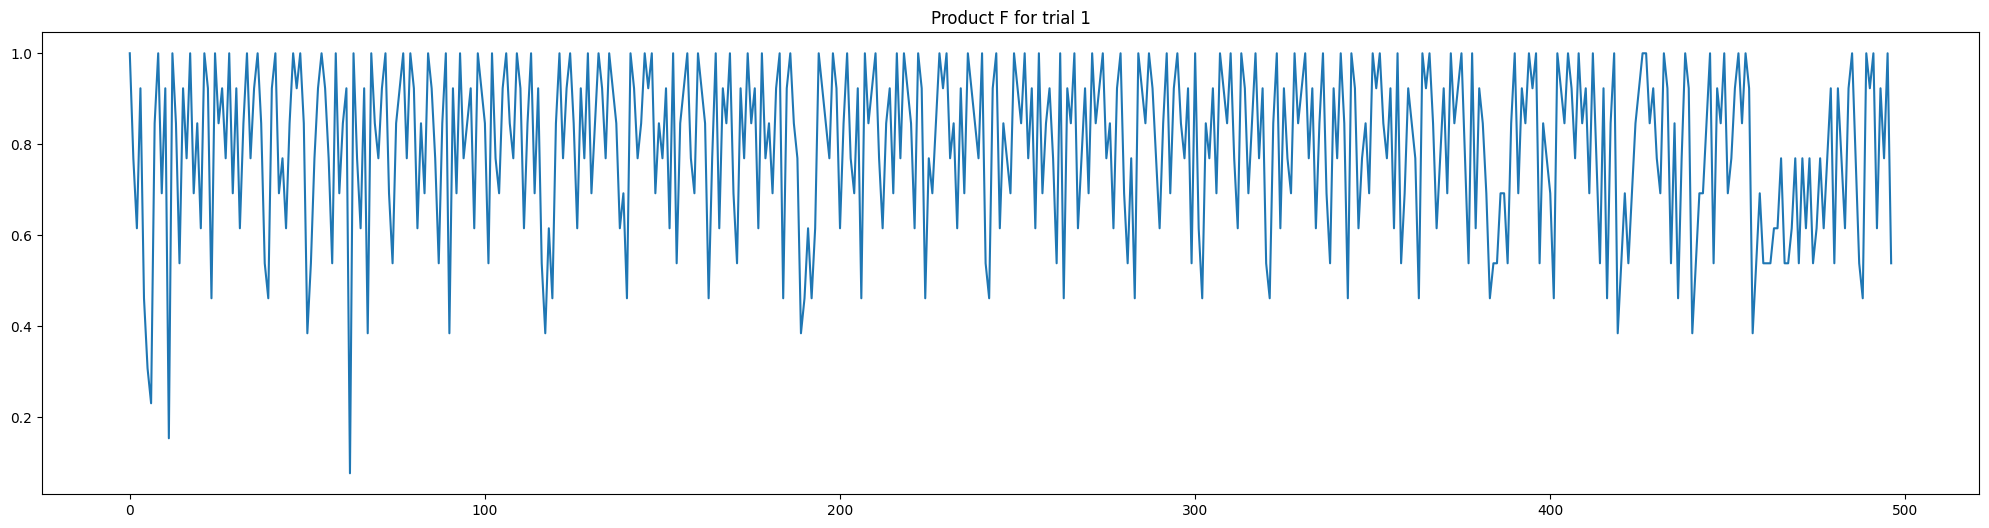

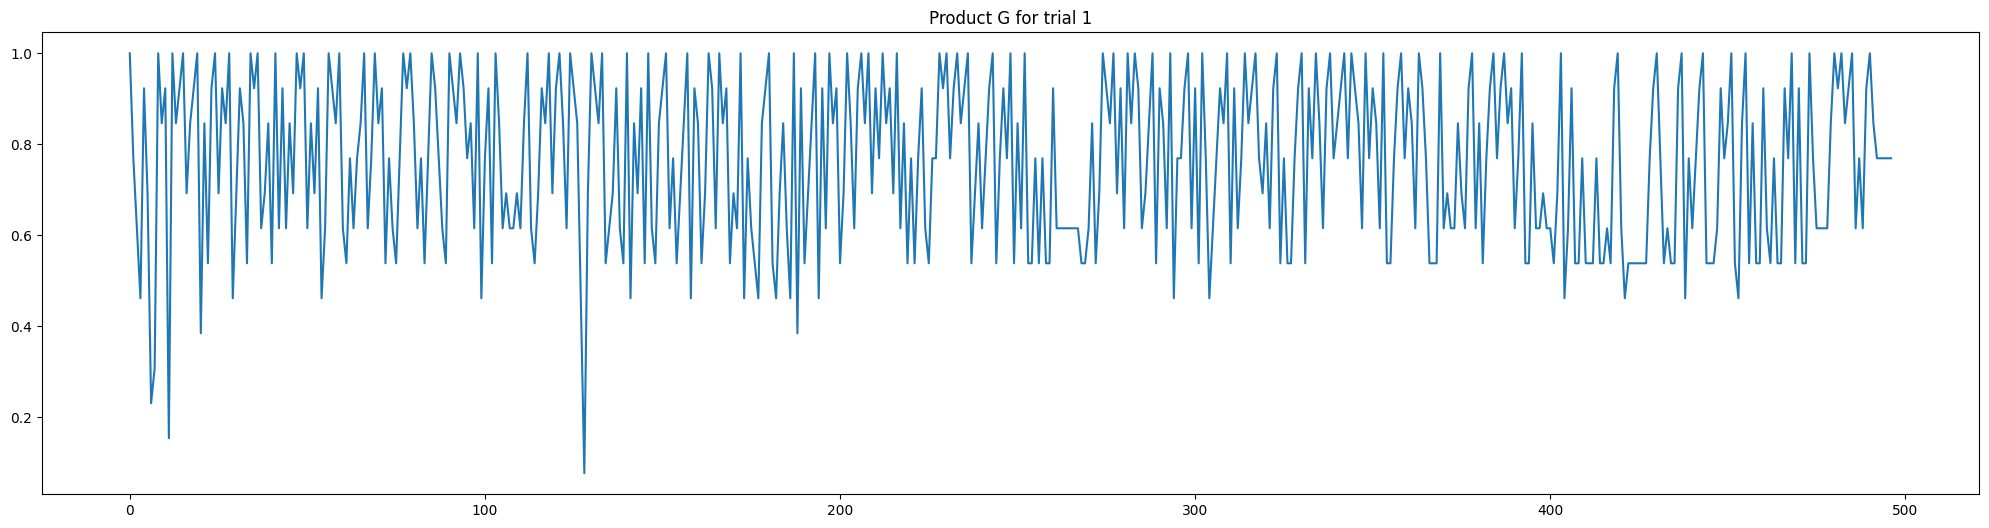

In [ ]:
"""Prepare actions for plotting: 
- if a single trial was run, wrap it in a list to unify the format
- else, keep the list of trials as is.
"""
if run_one:
    actions_unpacked = [actions]
else:
    actions_unpacked = actions
    #actions_unpacked=[[trial] for trial in actions]

"""Plot the price trajectory chosen by the agent for the first 2 trials
Each plot shows the evolution of chosen prices for one product across rounds
"""
for t, trial in enumerate(actions_unpacked[:2]):
    x = range(len(trial))
    for i, product in enumerate(products):
        y = [step[i] for step in trial]
        plt.figure(figsize=(25,6))
        plt.plot(x, y)
        plt.title(f'Product {product} for trial {t}')
        plt.show()

### Trial with B < T and uncorrelated products

We consider a budget B less than the number of rounds T, with still uncorrelated valuations over the products.

Discretizing prices with 14 values


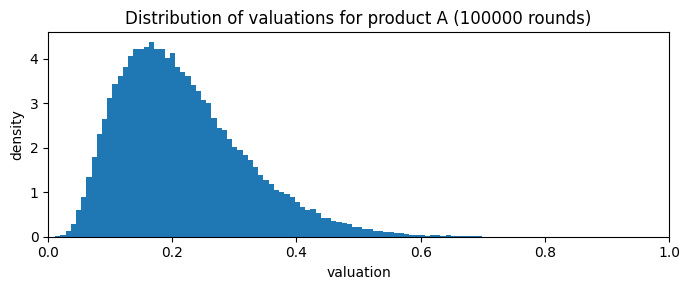

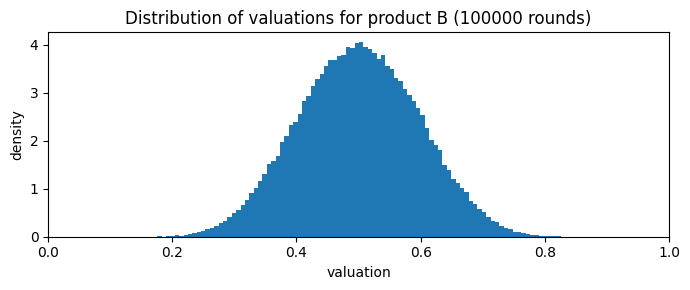

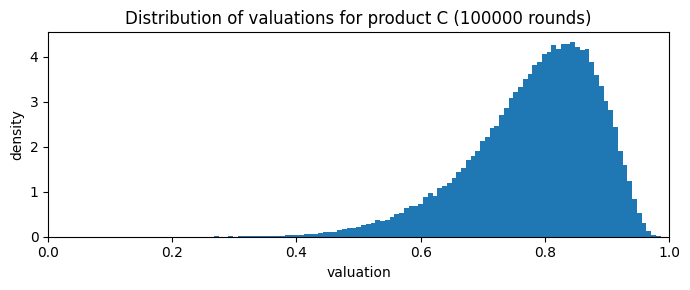

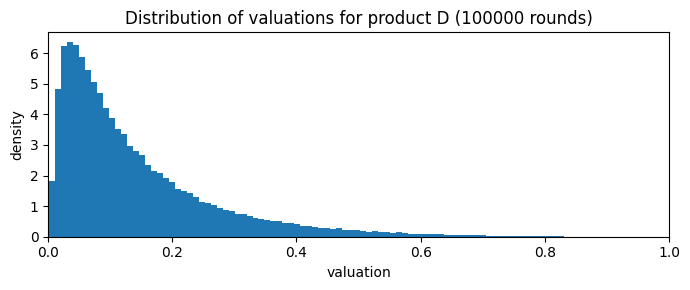

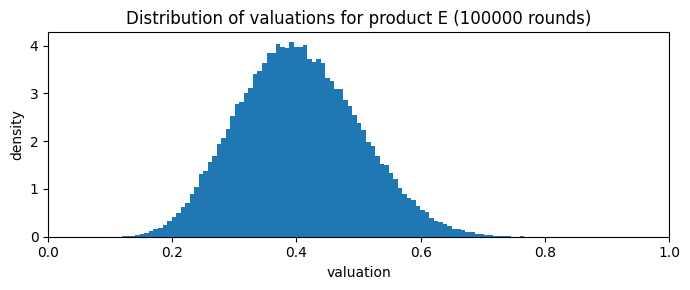

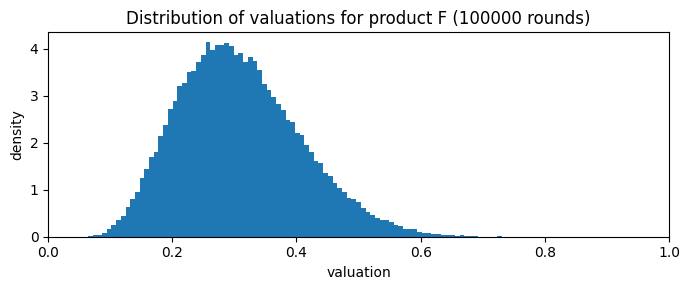

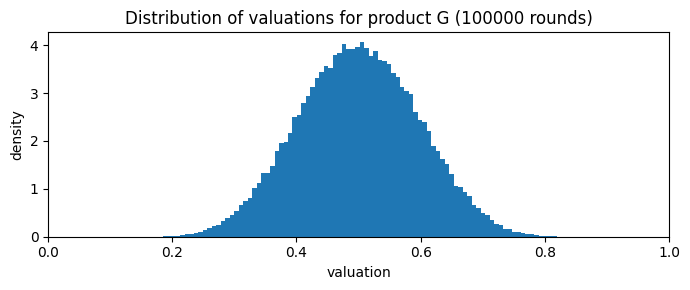

Trial 1:   0%|          | 0/500 [00:00<?, ?it/s]




















Trial 1:   2%|▏         | 12/500 [00:00<00:05, 95.61it/s]









































Trial 1:   4%|▍         | 22/500 [00:00<00:08, 55.27it/s]




















Trial 1:   6%|▌         | 29/500 [00:00<00:09, 50.23it/s]




















Trial 1:   7%|▋         | 35/500 [00:00<00:10, 45.51it/s]





























Trial 1:   8%|▊         | 40/500 [00:00<00:12, 36.91it/s]
































Trial 1:   9%|▉         | 44/500 [00:01<00:13, 33.72it/s]

















Trial 1:  10%|▉         | 48/500 [00:01<00:13, 33.98it/s]





















Trial 1:  10%|█         | 52/500 [00:01<00:13, 34.29it/s]



















Trial 1:  11%|█         | 56/500 [00:01<00:12, 35.10it/s]














Trial 1:  12%|█▏        | 60/500 [00:01<00:12, 34.84it/s]












Trial 1:  13%|█▎        | 65/500 [00:01<00:11, 36.47it/s]
















Trial 1:  14%|█▍        | 69/500 [00:01<00:14, 29.73

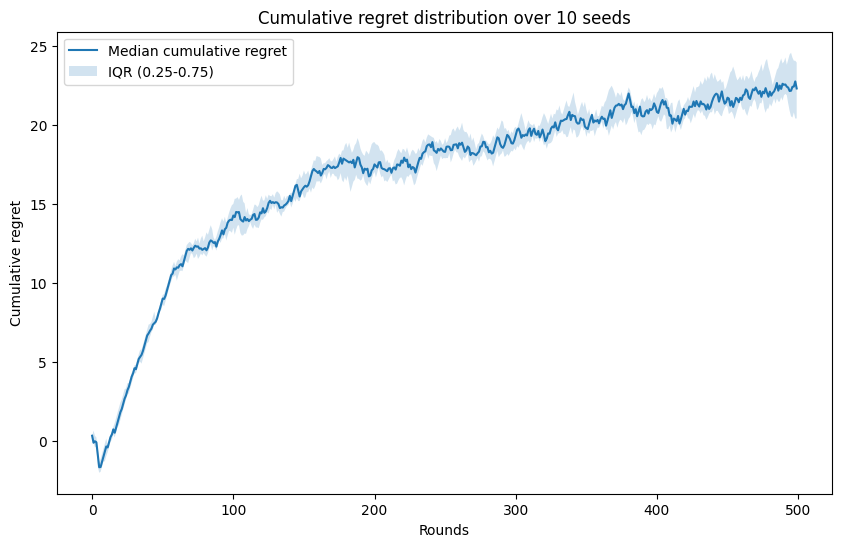

In [ ]:
"""
Experiment: Trial with very tight budget (B = 200 << T = 500) and uncorrelated products

Purpose:
- Test the Optimistic Bandit agent under a severely budget-constrained regime.
- Total budget is much smaller than the horizon, so the agent must learn quickly and
  carefully allocate its limited units to maximize cumulative reward.

Setup:
- 7 products with independent small-variance valuations.
- Price space discretized into K = 2/epsilon points, where epsilon = T^(-1/3).
- Run multiple trials (seeds) in parallel to capture distribution of outcomes.

Procedure:
- Environment generates product valuations from uncorrelated logit-normal distributions.
- Agent interacts for T rounds or until budget exhausted.
- Track cumulative regret vs. clairvoyant optimal policy.
- Aggregate results across seeds and compute median and interquartile range (IQR).

Output:
- Plot showing median cumulative regret over time with IQR shaded, reflecting learning 
  efficiency under extreme budget scarcity.
"""
run_one = False
products = ['A','B','C', 'D', 'E', 'F', 'G']
budget = 200
T = 500
seeds = [23424,3431,65762,842357,2346532,13564,98765,2557,123564,12364]
epsilon = T ** (-0.33)
# The two was chosen empirically
K = 2*int(1 / epsilon)
print(f'Discretizing prices with {K} values')
prices_per_product = np.linspace(0, 1, K)
means = np.array([0.2, 0.5, 0.8, 0.1, 0.4, 0.3, 0.5])
vars = 0.01*np.ones(len(products))
covs = 0.*np.min(vars)*np.ones((len(products), len(products)))
np.fill_diagonal(covs, vars)
# Just to plot distribution
env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, plot_distribution=True)

if run_one:
    cum_regret, actions = run_single_trial(0, products, prices_per_product, budget, T, means, covs, seed=3, extensive_plots=False)
    median_regret = cum_regret
else:
    all_regrets, actions = run_all_trials_parallel(seeds, products, prices_per_product, budget, T, means, covs, n_jobs=-1)
    all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
    lq_regret, median_regret, hq_regret = np.quantile(all_regrets, q=[0.25, 0.5, 0.75], axis=0)

plt.figure(figsize=(10,6))
plt.plot(median_regret, label='Median cumulative regret')
if not run_one:
    plt.fill_between(range(T), lq_regret, hq_regret, alpha=0.2, label='IQR (0.25-0.75)')
plt.xlabel('Rounds')
plt.ylabel('Cumulative regret')
plt.title(f'Cumulative regret distribution over {len(seeds)} seeds')
plt.legend()
plt.show()

We can see that the regret appears also in this case to be **sublinear**.

### Trial with B >> T and correlated products

This trial, differently from the previous ones, assumes correlated valuations over the products. The budget B is way greater than the number of rounds T.

Discretizing prices with 14 values


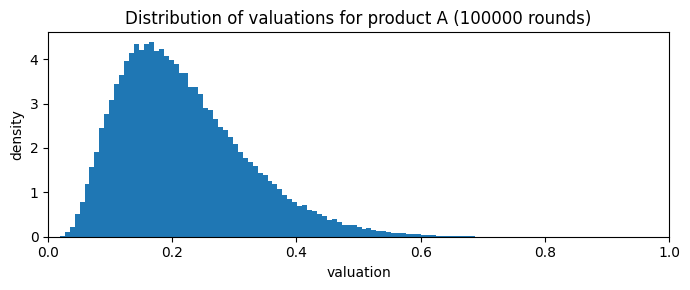

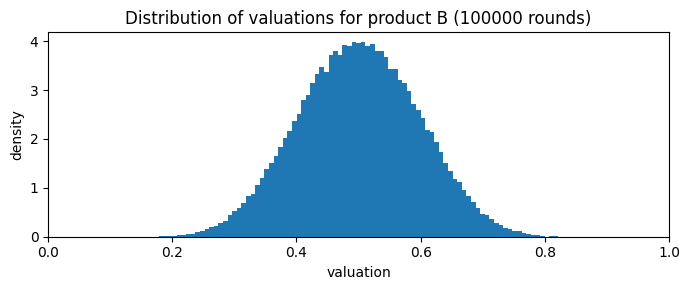

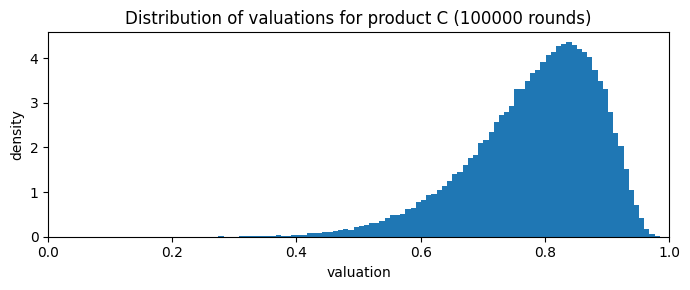

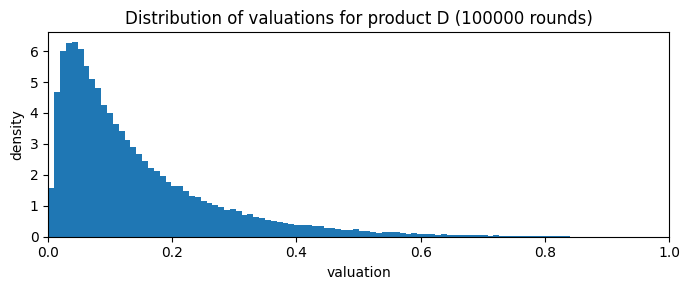

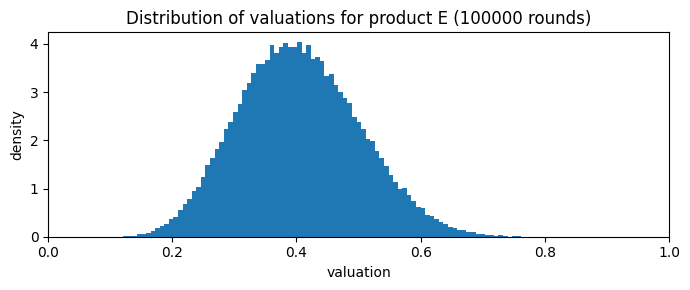

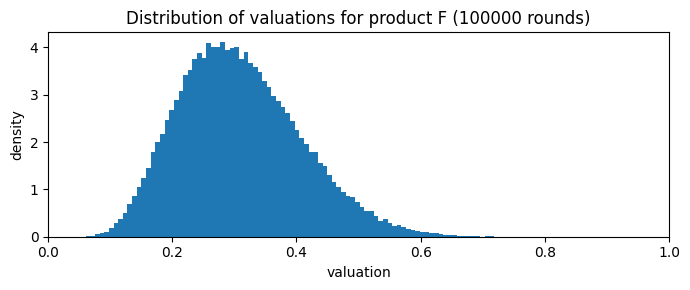

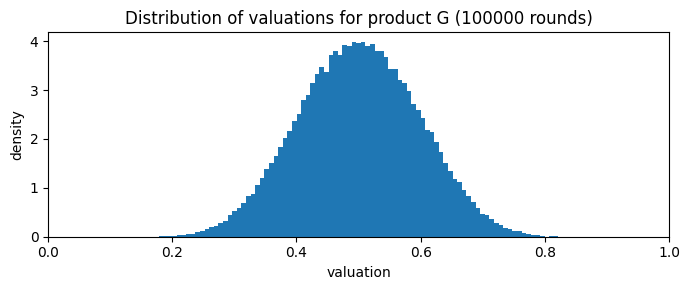


Trial 1:   0%|          | 0/500 [00:00<?, ?it/s]







Trial 1:   1%|          | 4/500 [00:00<00:14, 33.51it/s]














Trial 1:   2%|▏         | 8/500 [00:00<00:13, 36.63it/s]














Trial 1:   2%|▏         | 12/500 [00:00<00:13, 36.36it/s]














Trial 1:   3%|▎         | 16/500 [00:00<00:14, 34.29it/s]














Trial 1:   4%|▍         | 20/500 [00:00<00:13, 35.38it/s]

















Trial 1:   5%|▍         | 24/500 [00:00<00:13, 35.28it/s]














Trial 1:   6%|▌         | 28/500 [00:00<00:14, 32.78it/s]











Trial 1:   6%|▋         | 32/500 [00:00<00:14, 33.37it/s]

















Trial 1:   7%|▋         | 36/500 [00:01<00:13, 33.58it/s]



















Trial 1:   8%|▊         | 40/500 [00:01<00:13, 33.46it/s]









Trial 1:   9%|▉         | 44/500 [00:01<00:13, 33.38it/s]


























Trial 1:  10%|▉         | 48/500 [00:01<00:14, 31.08it/s]
















Trial 1:  10%|█         | 52/500 [00:01<00:13, 32.10it/s]








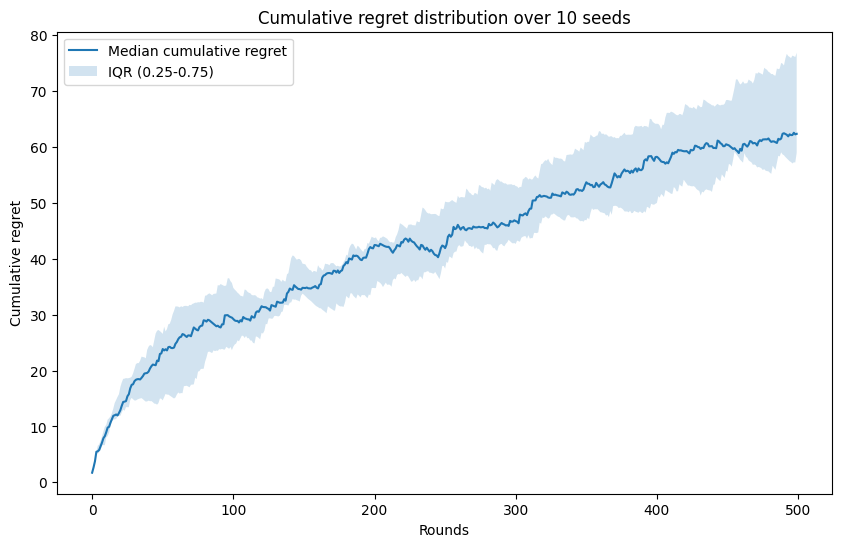

In [ ]:
"""
Experiment: Trial with B >> T (Budget = 2000, Horizon = 500) and moderately correlated products

Purpose:
- Evaluate the Optimistic Bandit agent when the total budget is much larger than the horizon.
- Higher budget allows more exploration and reduces the pressure of budget exhaustion.

Setup:
- 7 products with small variances; covariance matrix includes some uniform off-diagonal correlations.
- Price space discretized into K = 2/epsilon points, where epsilon = T^(-1/3).
- Multiple independent trials run in parallel to estimate performance distribution.

Procedure:
- Environment generates product valuations from logit-normal distributions with specified mean and covariance.
- Agent interacts for T rounds, choosing prices and observing sales.
- Cumulative regret computed against clairvoyant optimal policy.
- Results aggregated across seeds; median and interquartile range (IQR) calculated.

Output:
- Plot showing median cumulative regret over time with IQR shaded, reflecting learning efficiency
  under a budget-rich regime where exploration is less constrained.
"""
run_one = False
products = ['A','B','C', 'D', 'E', 'F', 'G']
budget = 2000
T = 500
seeds = [23424,3431,65762,842357,2346532,13564,98765,2557,123564,12364]
epsilon = T ** (-0.33)
# The two was chosen empirically
K = 2*int(1 / epsilon)
print(f'Discretizing prices with {K} values')
prices_per_product = np.linspace(0, 1, K)
means = np.array([0.2, 0.5, 0.8, 0.1, 0.4, 0.3, 0.5])
vars = 0.01*np.ones(len(products))
covs = 1*np.min(vars)*np.ones((len(products), len(products)))
np.fill_diagonal(covs, vars)
# Just to plot distribution
env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, plot_distribution=True)

if run_one:
    cum_regret, actions = run_single_trial(0, products, prices_per_product, budget, T, means, covs, seed=3, extensive_plots=False)
    median_regret = cum_regret
else:
    all_regrets, actions = run_all_trials_parallel(seeds, products, prices_per_product, budget, T, means, covs, n_jobs=-1)
    all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
    lq_regret, median_regret, hq_regret = np.quantile(all_regrets, q=[0.25, 0.5, 0.75], axis=0)

plt.figure(figsize=(10,6))
plt.plot(median_regret, label='Median cumulative regret')
if not run_one:
    plt.fill_between(range(T), lq_regret, hq_regret, alpha=0.2, label='IQR (0.25-0.75)')
plt.xlabel('Rounds')
plt.ylabel('Cumulative regret')
plt.title(f'Cumulative regret distribution over {len(seeds)} seeds')
plt.legend()
plt.show()

The cumulative regret seems to be **sublinear**, although less flatten than the previous results. This depends on the specific instance of the trial and on the correlation.

### Trial with B = T and correlated products

The budget B is equal to the number of rounds T and the valuations over the products are correlated.

Discretizing prices with 14 values


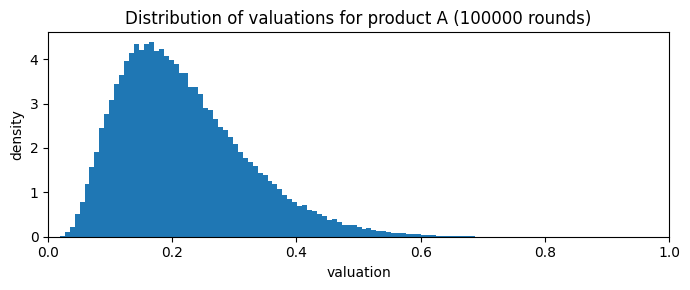

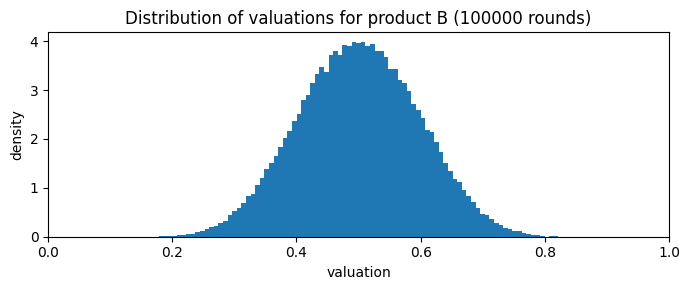

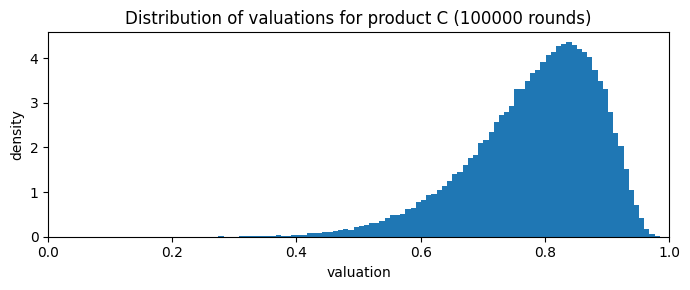

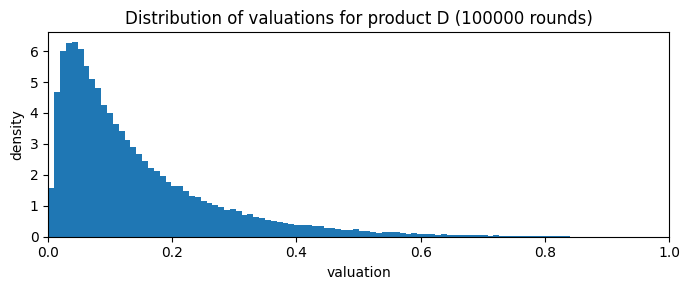

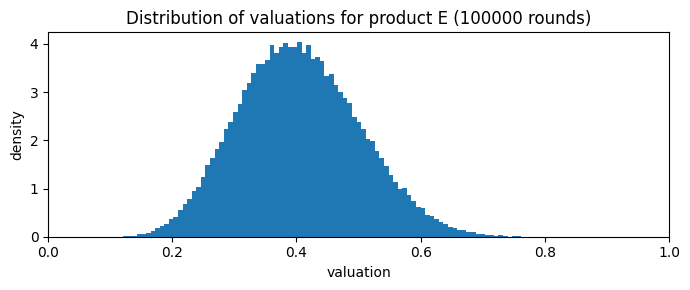

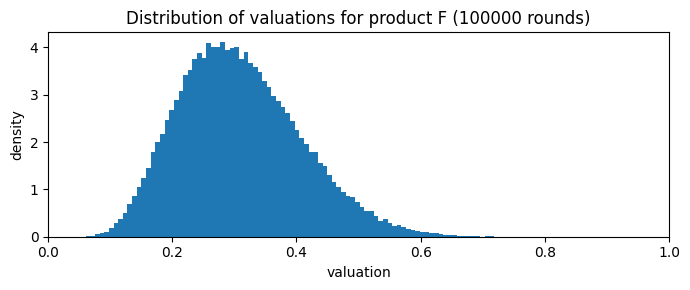

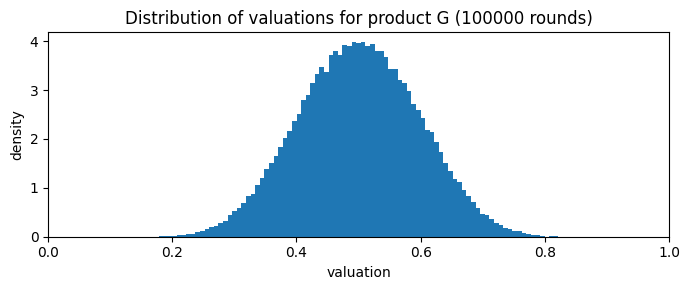

Trial 1:   0%|          | 0/500 [00:00<?, ?it/s]


Trial 1:   0%|          | 2/500 [00:00<00:27, 18.26it/s]

















Trial 1:   3%|▎         | 13/500 [00:00<00:07, 67.80it/s]




















Trial 1:   4%|▍         | 20/500 [00:00<00:08, 54.59it/s]











Trial 1:   5%|▌         | 26/500 [00:00<00:10, 46.54it/s]






















Trial 1:   6%|▌         | 31/500 [00:00<00:10, 43.54it/s]
















Trial 1:   7%|▋         | 36/500 [00:00<00:11, 41.66it/s]





























Trial 1:   8%|▊         | 41/500 [00:01<00:14, 32.18it/s]





















Trial 1:  10%|▉         | 48/500 [00:01<00:11, 38.52it/s]














Trial 1:  11%|█         | 53/500 [00:01<00:10, 40.66it/s]

















Trial 1:  12%|█▏        | 58/500 [00:01<00:10, 40.39it/s]




















Trial 1:  13%|█▎        | 63/500 [00:01<00:10, 40.15it/s]




















Trial 1:  14%|█▎        | 68/500 [00:01<00:10, 39.80it/s]




















Trial 1:  15%|█▍        | 7

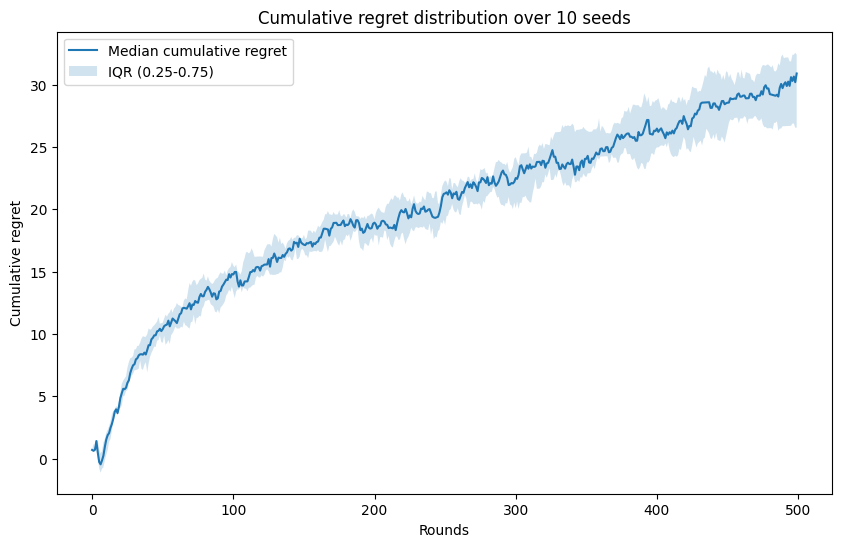

In [ ]:
"""
Experiment: Trial with budget equal to horizon (B = T = 500) and moderately correlated products

Purpose:
- Evaluate the Optimistic Bandit agent under a scenario where the budget is exactly equal to the
  number of rounds. This tight budget forces the agent to carefully balance exploration and exploitation.

Setup:
- 7 products with small independent variances; covariance matrix includes uniform off-diagonal values.
- Price space discretized into K = 2/epsilon points, with epsilon = T^(-1/3) (empirical choice).
- Multiple independent trials run in parallel to capture variability in learning outcomes.

Procedure:
- Environment generates product valuations from logit-normal distributions with specified mean and covariance.
- Agent selects prices for each round and observes sales until T rounds or budget exhaustion.
- Cumulative regret is calculated relative to a clairvoyant policy that knows the true probabilities.
- Results across trials are aggregated to compute median and interquartile range (IQR).

Output:
- Plot shows median cumulative regret over rounds with shaded IQR, illustrating learning performance
  under a tight budget constraint where exploration must be cautious.
"""

run_one = False
products = ['A','B','C', 'D', 'E', 'F', 'G']
budget = 500
T = 500
seeds = [23424,3431,65762,842357,2346532,13564,98765,2557,123564,12364]
epsilon = T ** (-0.33)
# The two was chosen empirically
K = 2*int(1 / epsilon)
print(f'Discretizing prices with {K} values')
prices_per_product = np.linspace(0, 1, K)
means = np.array([0.2, 0.5, 0.8, 0.1, 0.4, 0.3, 0.5])
vars = 0.01*np.ones(len(products))
covs = 1*np.min(vars)*np.ones((len(products), len(products)))
np.fill_diagonal(covs, vars)
# Just to plot distribution
env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, plot_distribution=True)

if run_one:
    cum_regret, actions = run_single_trial(0, products, prices_per_product, budget, T, means, covs, seed=3, extensive_plots=False)
    median_regret = cum_regret
else:
    all_regrets, actions = run_all_trials_parallel(seeds, products, prices_per_product, budget, T, means, covs, n_jobs=-1)
    all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
    lq_regret, median_regret, hq_regret = np.quantile(all_regrets, q=[0.25, 0.5, 0.75], axis=0)

plt.figure(figsize=(10,6))
plt.plot(median_regret, label='Median cumulative regret')
if not run_one:
    plt.fill_between(range(T), lq_regret, hq_regret, alpha=0.2, label='IQR (0.25-0.75)')
plt.xlabel('Rounds')
plt.ylabel('Cumulative regret')
plt.title(f'Cumulative regret distribution over {len(seeds)} seeds')
plt.legend()
plt.show()

The cumulative regret appears to be **sublinear** over time.

### Trial with B < T and correlated products

Now, the budget B is less than the number of rounds T, and the products' valuations are still correlated.

Discretizing prices with 14 values


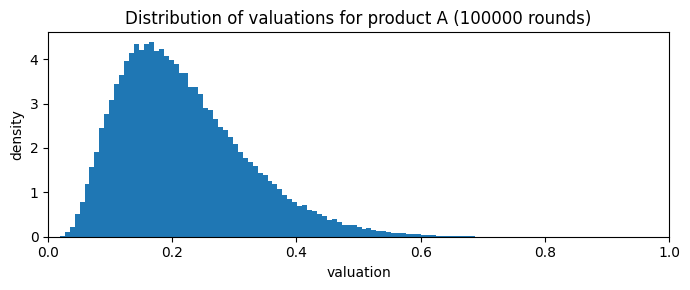

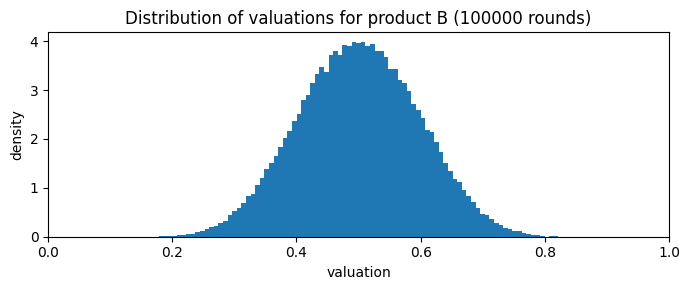

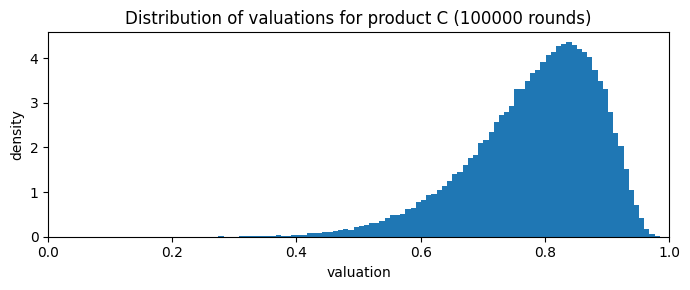

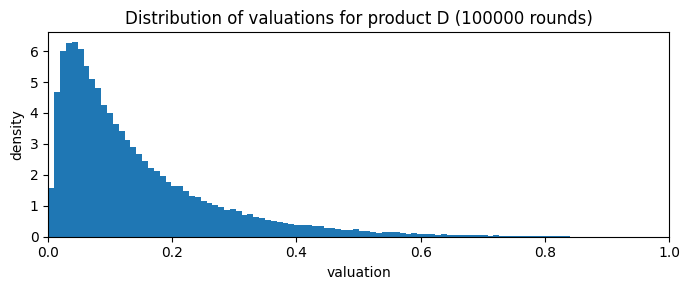

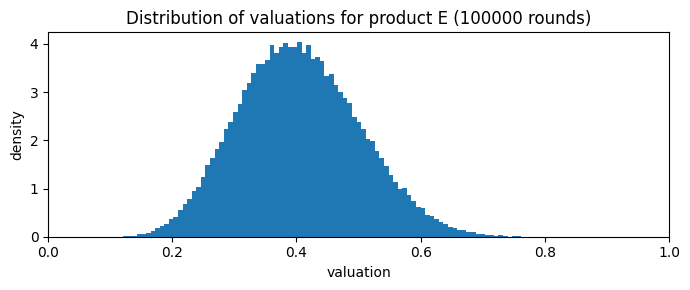

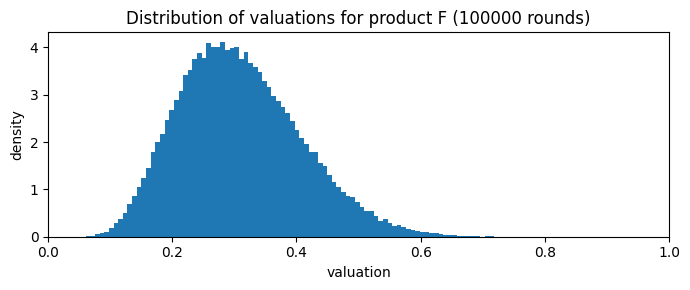

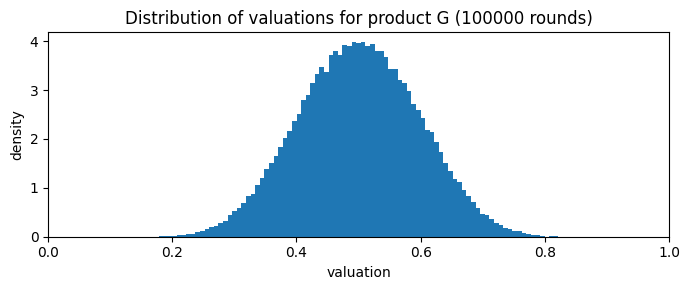

Trial 1:   0%|          | 0/500 [00:00<?, ?it/s]

















Trial 1:   2%|▏         | 12/500 [00:00<00:04, 97.80it/s]


























Trial 1:   4%|▍         | 22/500 [00:00<00:07, 62.26it/s]































Trial 1:   6%|▌         | 29/500 [00:00<00:09, 49.40it/s]
























Trial 1:   7%|▋         | 35/500 [00:00<00:10, 43.87it/s]




























Trial 1:   8%|▊         | 40/500 [00:00<00:14, 31.44it/s]




















Trial 1:  10%|█         | 51/500 [00:01<00:09, 45.99it/s]




















Trial 1:  11%|█▏        | 57/500 [00:01<00:10, 42.96it/s]



























Trial 1:  13%|█▎        | 63/500 [00:01<00:11, 39.49it/s]


























Trial 1:  14%|█▎        | 68/500 [00:01<00:11, 38.30it/s]




















Trial 1:  15%|█▍        | 73/500 [00:01<00:11, 36.65it/s]














Trial 1:  15%|█▌        | 77/500 [00:01<00:11, 36.14it/s]


























Trial 1:  16%|█▌        | 81/500 [

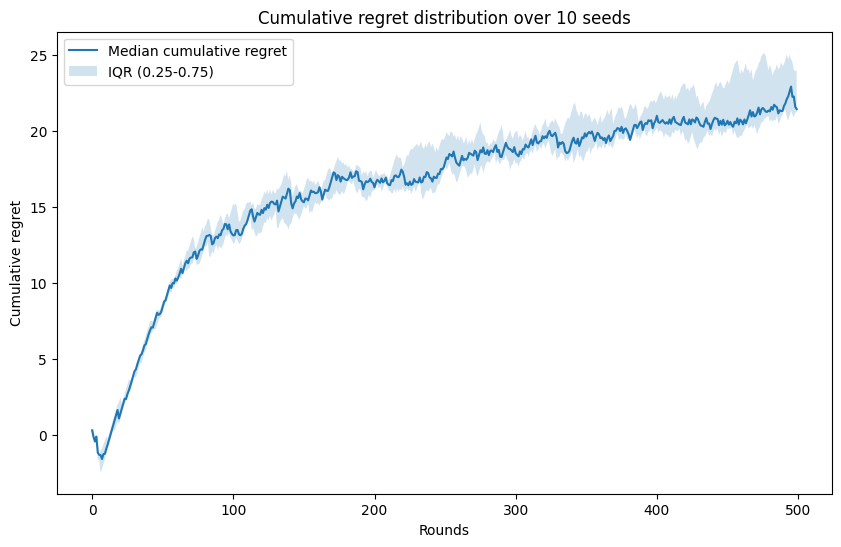

In [ ]:
"""
Experiment: Trial with very tight budget (B = 200 << T = 500) and moderately correlated products

Purpose:
- Evaluate the Optimistic Bandit agent under severe budget constraints.
- Limited budget forces the agent to learn quickly and make careful trade-offs between
  exploration and exploitation.

Setup:
- 7 products with small independent variances; covariance matrix includes uniform off-diagonal correlations.
- Price space discretized into K = 2/epsilon points, with epsilon = T^(-1/3).
- Multiple independent trials are run in parallel to assess variability of learning outcomes.

Procedure:
- Environment generates product valuations from logit-normal distributions.
- Agent selects prices for each round until the budget is exhausted or T rounds complete.
- Cumulative regret is measured against a clairvoyant benchmark that knows true probabilities.
- Results are aggregated across trials to compute median and interquartile range (IQR).

Output:
- Plot showing median cumulative regret over rounds with IQR shaded,
  illustrating agent performance under extreme budget scarcity.
"""

run_one = False
products = ['A','B','C', 'D', 'E', 'F', 'G']
budget = 200
T = 500
seeds = [23424,3431,65762,842357,2346532,13564,98765,2557,123564,12364]
epsilon = T ** (-0.33)
# The two was chosen empirically
K = 2*int(1 / epsilon)
print(f'Discretizing prices with {K} values')
prices_per_product = np.linspace(0, 1, K)
means = np.array([0.2, 0.5, 0.8, 0.1, 0.4, 0.3, 0.5])
vars = 0.01*np.ones(len(products))
covs = 1*np.min(vars)*np.ones((len(products), len(products)))
np.fill_diagonal(covs, vars)
# Just to plot distribution
env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, plot_distribution=True)

if run_one:
    cum_regret, actions = run_single_trial(0, products, prices_per_product, budget, T, means, covs, seed=3, extensive_plots=False)
    median_regret = cum_regret
else:
    all_regrets, actions = run_all_trials_parallel(seeds, products, prices_per_product, budget, T, means, covs, n_jobs=-1)
    all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
    lq_regret, median_regret, hq_regret = np.quantile(all_regrets, q=[0.25, 0.5, 0.75], axis=0)

plt.figure(figsize=(10,6))
plt.plot(median_regret, label='Median cumulative regret')
if not run_one:
    plt.fill_between(range(T), lq_regret, hq_regret, alpha=0.2, label='IQR (0.25-0.75)')
plt.xlabel('Rounds')
plt.ylabel('Cumulative regret')
plt.title(f'Cumulative regret distribution over {len(seeds)} seeds')
plt.legend()
plt.show()

The cumulative regret seems to be **sublinear**

We increase variance and decrease covariance

Discretizing prices with 14 values


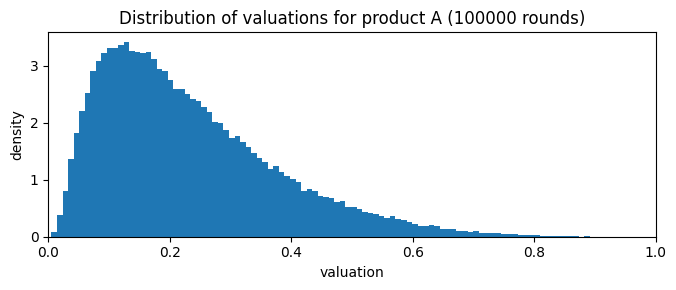

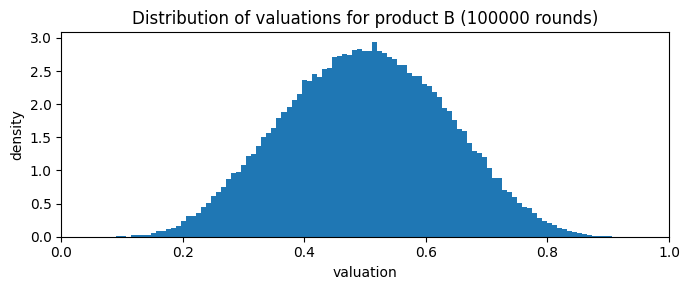

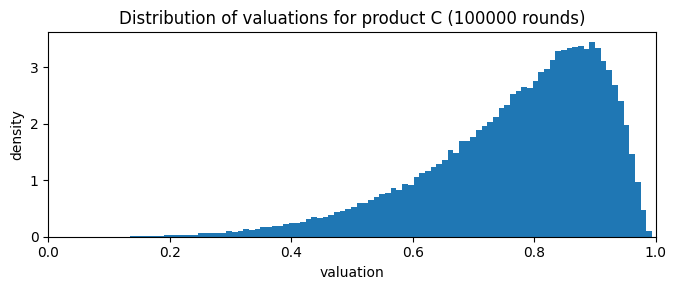

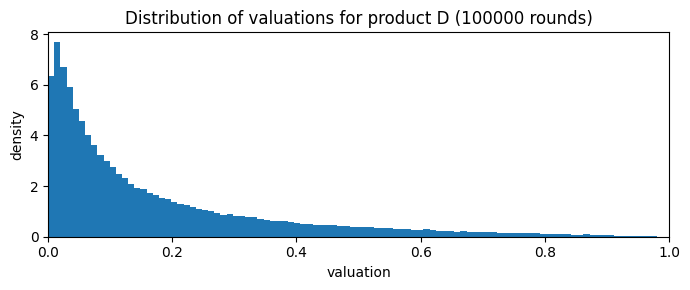

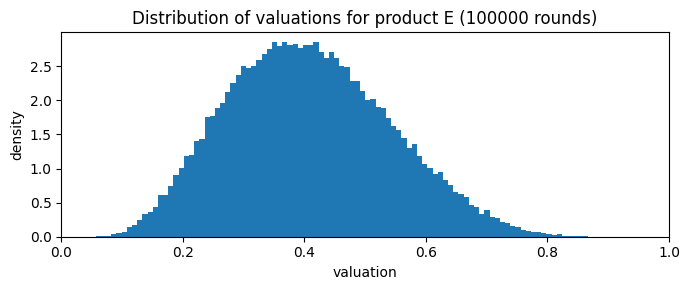

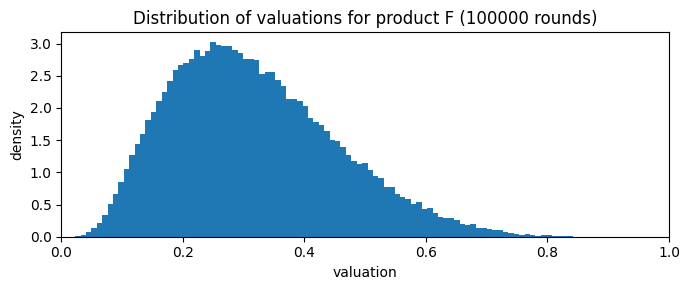

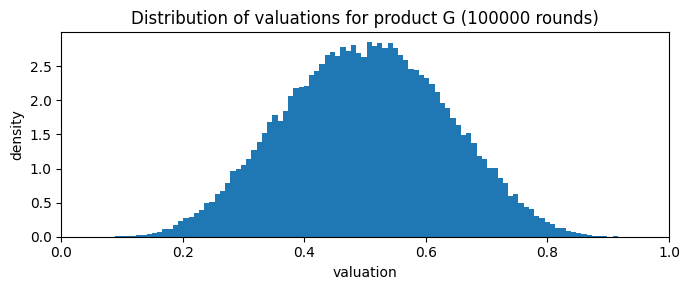



Trial 1:   0%|          | 0/500 [00:00<?, ?it/s]




Trial 1:   1%|          | 5/500 [00:00<00:11, 43.02it/s]









Trial 1:   2%|▏         | 11/500 [00:00<00:10, 47.99it/s]















Trial 1:   3%|▎         | 16/500 [00:00<00:10, 47.71it/s]















Trial 1:   4%|▍         | 21/500 [00:00<00:10, 46.33it/s]





















Trial 1:   5%|▌         | 26/500 [00:00<00:10, 45.16it/s]



















Trial 1:   6%|▌         | 31/500 [00:00<00:10, 44.61it/s]
















Trial 1:   7%|▋         | 36/500 [00:00<00:10, 44.35it/s]














Trial 1:   8%|▊         | 41/500 [00:00<00:12, 37.41it/s]



























Trial 1:   9%|▉         | 47/500 [00:01<00:11, 40.53it/s]






















Trial 1:  10%|█         | 52/500 [00:01<00:11, 37.71it/s]















Trial 1:  11%|█▏        | 57/500 [00:01<00:13, 32.95it/s]














Trial 1:  13%|█▎        | 63/500 [00:01<00:11, 38.32it/s]
























Trial 1:  14%|█▎        | 68/500 [00:01

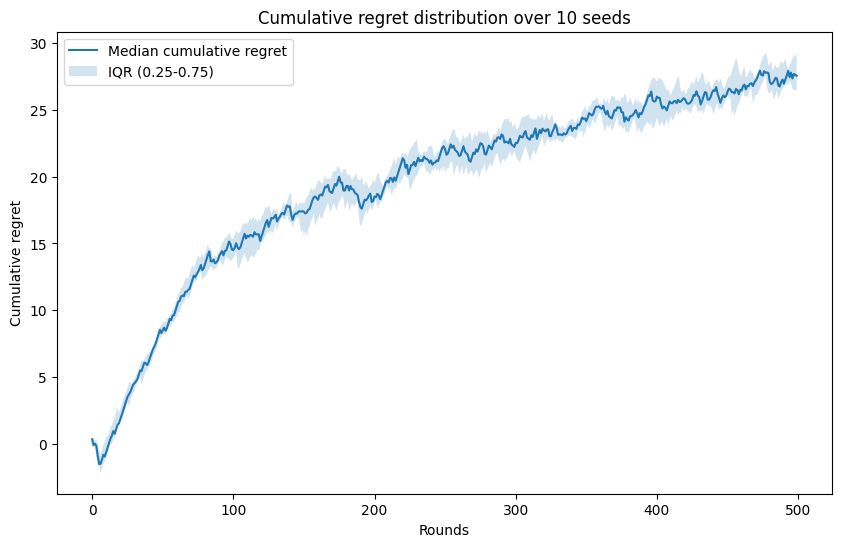

In [ ]:
"""
Experiment: Trial with tight budget (B = 200) and moderately correlated products

Purpose:
- Evaluate the Optimistic Bandit agent under a scenario with limited budget relative to the horizon.
- Moderate correlations among products add dependencies in sales, increasing learning complexity.

Setup:
- 7 products with small variances; covariance matrix has off-diagonal values at 0.8 * min(variance).
- Price space discretized into K = 2/epsilon points, with epsilon = T^(-1/3), chosen empirically.
- Multiple independent trials are run in parallel to capture variability in agent performance.

Procedure:
- Environment generates product valuations from logit-normal distributions with specified means and covariance.
- Agent interacts for up to T rounds, selecting prices and observing sales, stopping early if budget is exhausted.
- Cumulative regret is computed against the clairvoyant benchmark.
- Results across trials are aggregated to compute median and interquartile range (IQR).

Output:
- Plot shows median cumulative regret over rounds with IQR shaded,
  reflecting learning efficiency under budget scarcity and moderate product correlations.
"""

run_one = False
products = ['A','B','C', 'D', 'E', 'F', 'G']
budget = 200
T = 500
seeds = [23424,3431,65762,842357,2346532,13564,98765,2557,123564,12364]
epsilon = T ** (-0.33)
# The two was chosen empirically
K = 2*int(1 / epsilon)
print(f'Discretizing prices with {K} values')
prices_per_product = np.linspace(0, 1, K)
means = np.array([0.2, 0.5, 0.8, 0.1, 0.4, 0.3, 0.5])
vars = 0.02*np.ones(len(products))
covs = 0.8*np.min(vars)*np.ones((len(products), len(products)))
np.fill_diagonal(covs, vars)
# Just to plot distribution
env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, plot_distribution=True)

if run_one:
    cum_regret, actions = run_single_trial(0, products, prices_per_product, budget, T, means, covs, seed=3, extensive_plots=False)
    median_regret = cum_regret
else:
    all_regrets, actions = run_all_trials_parallel(seeds, products, prices_per_product, budget, T, means, covs, n_jobs=-1)
    all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
    lq_regret, median_regret, hq_regret = np.quantile(all_regrets, q=[0.25, 0.5, 0.75], axis=0)

plt.figure(figsize=(10,6))
plt.plot(median_regret, label='Median cumulative regret')
if not run_one:
    plt.fill_between(range(T), lq_regret, hq_regret, alpha=0.2, label='IQR (0.25-0.75)')
plt.xlabel('Rounds')
plt.ylabel('Cumulative regret')
plt.title(f'Cumulative regret distribution over {len(seeds)} seeds')
plt.legend()
plt.show()

With increased variance and decreased covariance, we still get **sublinear** cumulative regret. 

### Trials with custom covariance matrix

Now, we use a custom covariance matrix. Up to this point, we used a covariance matrix whose values outside the principal diagonal were all the same. From now on, we use a covariance matrix whose values are different and there are products that are correlated and products that are not correlated.

##### Trial with B >> T

We start with budget B greater than number of rounds T.

Discretizing prices with 14 values
Covariance matrix:
 [[0.02  0.014 0.014 0.    0.    0.    0.   ]
 [0.014 0.02  0.014 0.    0.    0.    0.   ]
 [0.014 0.014 0.02  0.    0.    0.    0.   ]
 [0.    0.    0.    0.02  0.01  0.    0.   ]
 [0.    0.    0.    0.01  0.02  0.    0.   ]
 [0.    0.    0.    0.    0.    0.02  0.006]
 [0.    0.    0.    0.    0.    0.006 0.02 ]]


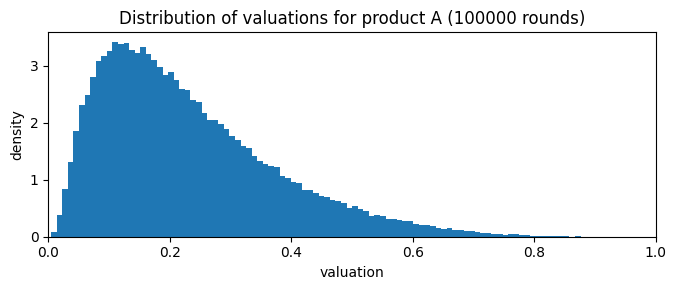

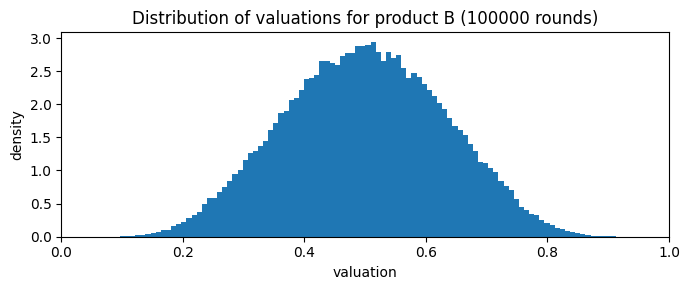

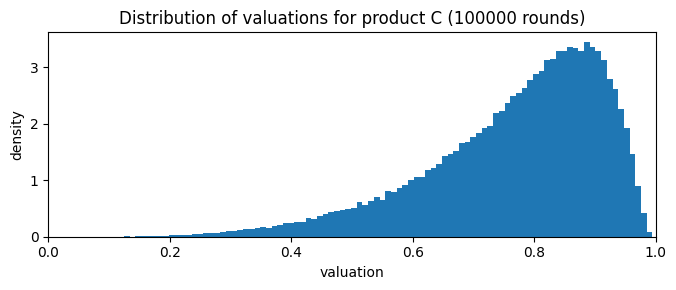

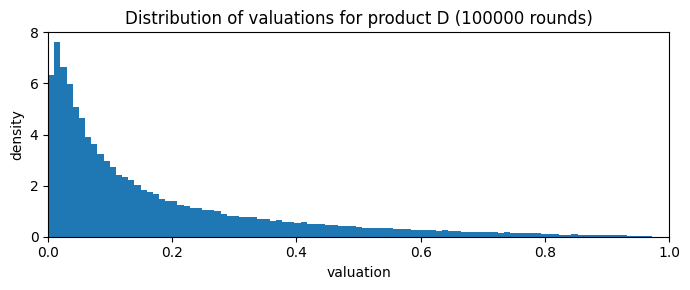

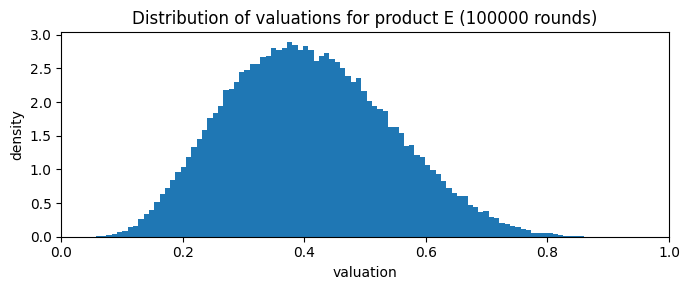

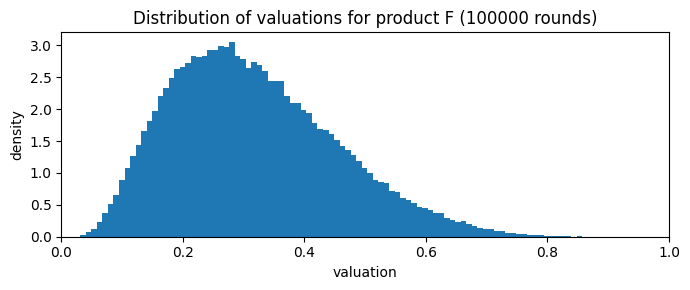

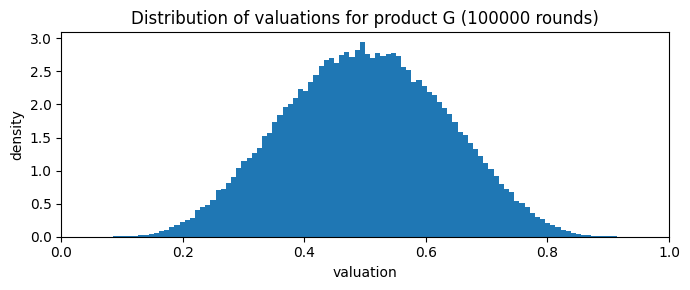


Trial 1:   0%|          | 0/500 [00:00<?, ?it/s]





Trial 1:   1%|          | 4/500 [00:00<00:13, 35.79it/s]












Trial 1:   2%|▏         | 9/500 [00:00<00:13, 37.52it/s]












Trial 1:   3%|▎         | 13/500 [00:00<00:12, 38.46it/s]













Trial 1:   4%|▎         | 18/500 [00:00<00:11, 40.67it/s]















Trial 1:   5%|▍         | 23/500 [00:00<00:12, 38.97it/s]














Trial 1:   5%|▌         | 27/500 [00:00<00:12, 38.85it/s]






Trial 1:   6%|▌         | 31/500 [00:00<00:12, 38.38it/s]




















Trial 1:   7%|▋         | 35/500 [00:00<00:12, 38.26it/s]




















Trial 1:   8%|▊         | 39/500 [00:01<00:12, 37.73it/s]




















Trial 1:   9%|▊         | 43/500 [00:01<00:12, 36.47it/s]
























Trial 1:   9%|▉         | 47/500 [00:01<00:13, 34.72it/s]




















Trial 1:  10%|█         | 51/500 [00:01<00:14, 31.60it/s]




















Trial 1:  11%|█         | 55/500 [00:01<00:13, 31.93it/

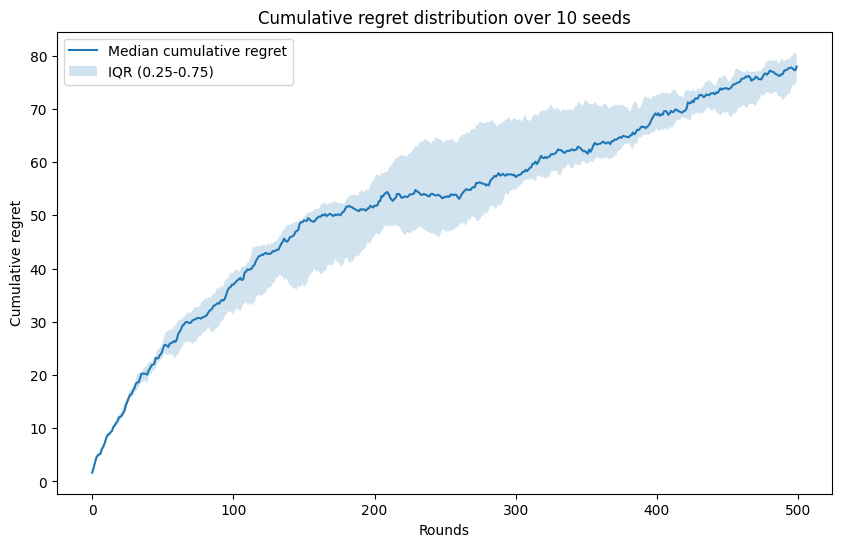

In [ ]:
"""
Experiment: Clustered product correlations with increased budget (B = 2000, T = 500)

Purpose:
- Evaluate the Optimistic Bandit agent when products are grouped into clusters with different
  levels of positive correlation, reflecting realistic inter-product dependencies.
- Higher budget allows more rounds of exploration and exploitation.

Setup:
- 7 products divided into three clusters:
    Cluster 1 (A, B, C): strong correlation (0.7)
    Cluster 2 (D, E): moderate correlation (0.5)
    Cluster 3 (F, G): weak correlation (0.3)
- Diagonal variances set uniformly (0.02), off-diagonal entries reflect the cluster correlations.
- Price space discretized into K = 2/epsilon points, with epsilon = T^(-1/3).
- Multiple independent trials run in parallel to capture variability.

Procedure:
- Environment generates product valuations from a logit-normal distribution using the covariance matrix.
- Agent chooses prices each round until budget exhausted or T rounds complete.
- Cumulative regret measured against a clairvoyant benchmark.
- Results aggregated across trials to compute median and interquartile range (IQR).

Output:
- Plot showing median cumulative regret over rounds with IQR shaded,
  illustrating agent performance under clustered product correlations and generous budget.
"""

run_one = False
products = ['A','B','C', 'D', 'E', 'F', 'G']
budget = 2000
T = 500
seeds = [23424,3431,65762,842357,2346532,13564,98765,2557,123564,12364]
epsilon = T ** (-0.33)
# The two was chosen empirically
K = 2*int(1 / epsilon)
print(f'Discretizing prices with {K} values')
prices_per_product = np.linspace(0, 1, K)
means = np.array([0.2, 0.5, 0.8, 0.1, 0.4, 0.3, 0.5])
vars = 0.02*np.ones(len(products))
corr = np.eye(len(products))  # start with identity (each product correlated with itself)

# Cluster 1: A, B, C
for i in [0,1,2]:
    for j in [0,1,2]:
        if i != j:
            corr[i,j] = 0.7   # strong positive correlation
# Cluster 2: D, E
corr[3,4] = corr[4,3] = 0.5
# Cluster 3: F, G
corr[5,6] = corr[6,5] = 0.3
# Convert correlation → covariance
D = np.diag(np.sqrt(vars))
covs = D @ corr @ D
print("Covariance matrix:\n", covs)
# Just to plot distribution
env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, plot_distribution=True)

if run_one:
    cum_regret, actions = run_single_trial(0, products, prices_per_product, budget, T, means, covs, seed=3, extensive_plots=False)
    median_regret = cum_regret
else:
    all_regrets, actions = run_all_trials_parallel(seeds, products, prices_per_product, budget, T, means, covs, n_jobs=-1)
    all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
    lq_regret, median_regret, hq_regret = np.quantile(all_regrets, q=[0.25, 0.5, 0.75], axis=0)

plt.figure(figsize=(10,6))
plt.plot(median_regret, label='Median cumulative regret')
if not run_one:
    plt.fill_between(range(T), lq_regret, hq_regret, alpha=0.2, label='IQR (0.25-0.75)')
plt.xlabel('Rounds')
plt.ylabel('Cumulative regret')
plt.title(f'Cumulative regret distribution over {len(seeds)} seeds')
plt.legend()
plt.show()

We achieve **sublinear** cumulative regret, with more variance than before.

##### Trial with B = T

Now, budget B is equal to the number of rounds T.

Discretizing prices with 14 values
Covariance matrix:
 [[0.02  0.014 0.014 0.    0.    0.    0.   ]
 [0.014 0.02  0.014 0.    0.    0.    0.   ]
 [0.014 0.014 0.02  0.    0.    0.    0.   ]
 [0.    0.    0.    0.02  0.01  0.    0.   ]
 [0.    0.    0.    0.01  0.02  0.    0.   ]
 [0.    0.    0.    0.    0.    0.02  0.006]
 [0.    0.    0.    0.    0.    0.006 0.02 ]]


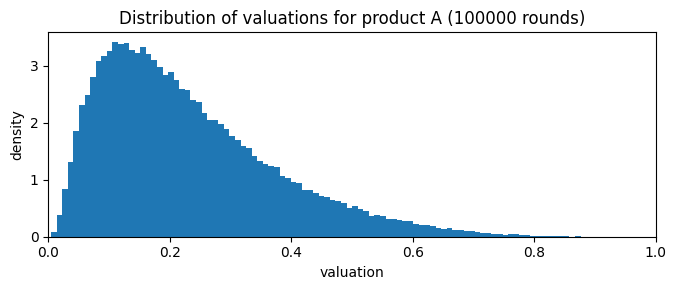

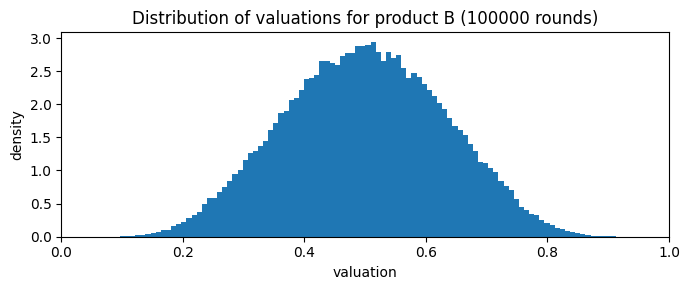

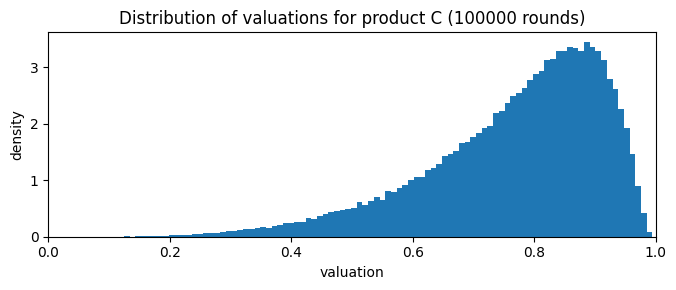

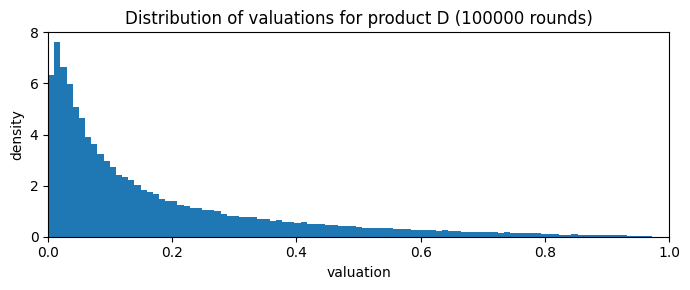

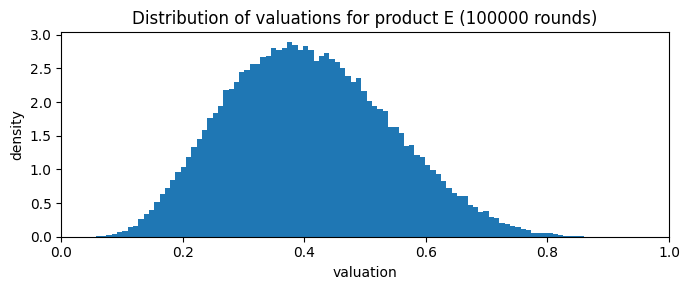

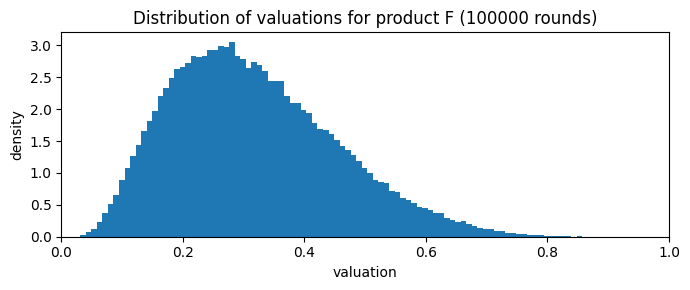

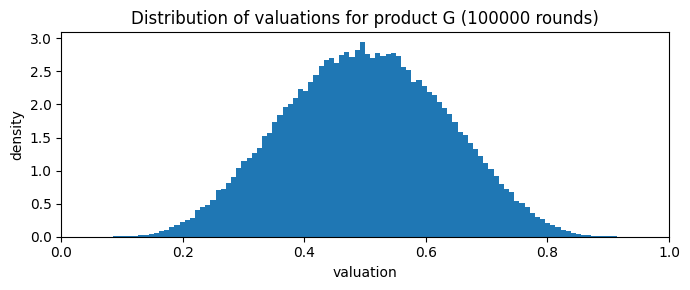

Trial 1:   0%|          | 0/500 [00:00<?, ?it/s]














Trial 1:   2%|▏         | 8/500 [00:00<00:06, 79.88it/s]














Trial 1:   3%|▎         | 16/500 [00:00<00:08, 55.72it/s]


























Trial 1:   4%|▍         | 22/500 [00:00<00:12, 39.46it/s]














Trial 1:   6%|▌         | 29/500 [00:00<00:10, 46.36it/s]




















Trial 1:   7%|▋         | 35/500 [00:00<00:11, 41.02it/s]


























Trial 1:   8%|▊         | 40/500 [00:00<00:13, 34.41it/s]





























Trial 1:   9%|▉         | 47/500 [00:01<00:11, 40.10it/s]










Trial 1:  10%|█         | 52/500 [00:01<00:10, 41.02it/s]























Trial 1:  11%|█▏        | 57/500 [00:01<00:11, 39.06it/s]




















Trial 1:  12%|█▏        | 62/500 [00:01<00:11, 37.58it/s]





















Trial 1:  13%|█▎        | 66/500 [00:01<00:12, 35.95it/s]









Trial 1:  14%|█▍        | 70/500 [00:01<00:11, 35.99it/s]











Trial 1:  15%|█▍   

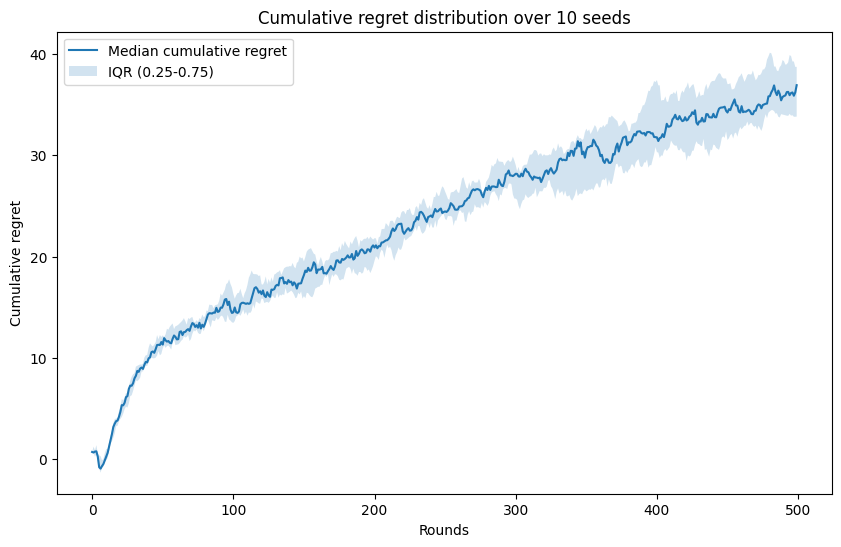

In [ ]:
"""
Experiment: Clustered correlations with limited budget (B = 500, T = 500)

Purpose:
- Evaluate the Optimistic Bandit agent under product clusters with positive correlations.
- Lower budget forces the agent to balance exploration and exploitation carefully.

Setup:
- 7 products divided into three clusters with correlations:
    Cluster 1 (A, B, C): 0.7
    Cluster 2 (D, E): 0.5
    Cluster 3 (F, G): 0.3
- Diagonal variances: 0.02; off-diagonal entries reflect cluster correlations.
- Price space discretized into K = 14 values (2 * T^0.33).
- Multiple seeds simulate independent trials.

Procedure:
- Environment samples product valuations using covariance matrix.
- Agent selects prices each round until budget is exhausted or T rounds reached.
- Cumulative regret measured against a clairvoyant benchmark.
- Aggregate results across seeds to get median and IQR.

Output:
- Plot of median cumulative regret over rounds with IQR shading,
  showing agent performance under correlated clusters with tighter budget.
"""

run_one = False
products = ['A','B','C', 'D', 'E', 'F', 'G']
budget = 500
T = 500
seeds = [23424,3431,65762,842357,2346532,13564,98765,2557,123564,12364]
epsilon = T ** (-0.33)
# The two was chosen empirically
K = 2*int(1 / epsilon)
print(f'Discretizing prices with {K} values')
prices_per_product = np.linspace(0, 1, K)
means = np.array([0.2, 0.5, 0.8, 0.1, 0.4, 0.3, 0.5])
vars = 0.02*np.ones(len(products))
corr = np.eye(len(products))  # start with identity (each product correlated with itself)

# Cluster 1: A, B, C
for i in [0,1,2]:
    for j in [0,1,2]:
        if i != j:
            corr[i,j] = 0.7   # strong positive correlation
# Cluster 2: D, E
corr[3,4] = corr[4,3] = 0.5
# Cluster 3: F, G
corr[5,6] = corr[6,5] = 0.3
# Convert correlation → covariance
D = np.diag(np.sqrt(vars))
covs = D @ corr @ D
print("Covariance matrix:\n", covs)
# Just to plot distribution
env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, plot_distribution=True)

if run_one:
    cum_regret, actions = run_single_trial(0, products, prices_per_product, budget, T, means, covs, seed=3, extensive_plots=False)
    median_regret = cum_regret
else:
    all_regrets, actions = run_all_trials_parallel(seeds, products, prices_per_product, budget, T, means, covs, n_jobs=-1)
    all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
    lq_regret, median_regret, hq_regret = np.quantile(all_regrets, q=[0.25, 0.5, 0.75], axis=0)

plt.figure(figsize=(10,6))
plt.plot(median_regret, label='Median cumulative regret')
if not run_one:
    plt.fill_between(range(T), lq_regret, hq_regret, alpha=0.2, label='IQR (0.25-0.75)')
plt.xlabel('Rounds')
plt.ylabel('Cumulative regret')
plt.title(f'Cumulative regret distribution over {len(seeds)} seeds')
plt.legend()
plt.show()

The cumulative regret is still **sublinear**.

##### Trial with B < T

And finally budget B is less than number of rounds T.

Discretizing prices with 14 values
Covariance matrix:
 [[0.02  0.014 0.014 0.    0.    0.    0.   ]
 [0.014 0.02  0.014 0.    0.    0.    0.   ]
 [0.014 0.014 0.02  0.    0.    0.    0.   ]
 [0.    0.    0.    0.02  0.01  0.    0.   ]
 [0.    0.    0.    0.01  0.02  0.    0.   ]
 [0.    0.    0.    0.    0.    0.02  0.006]
 [0.    0.    0.    0.    0.    0.006 0.02 ]]


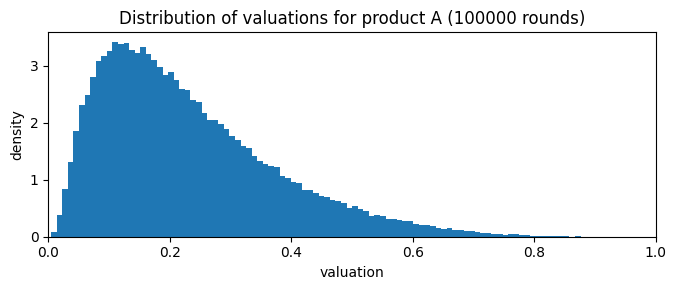

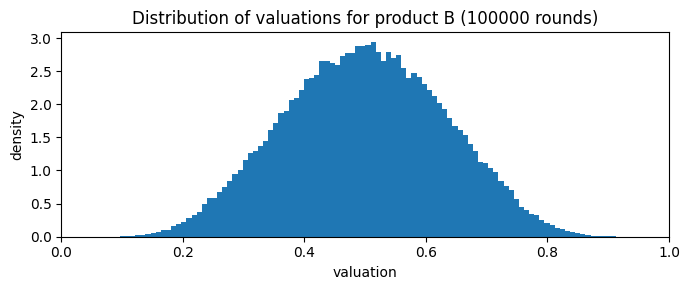

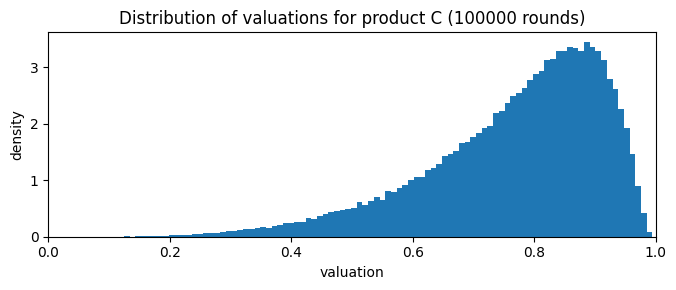

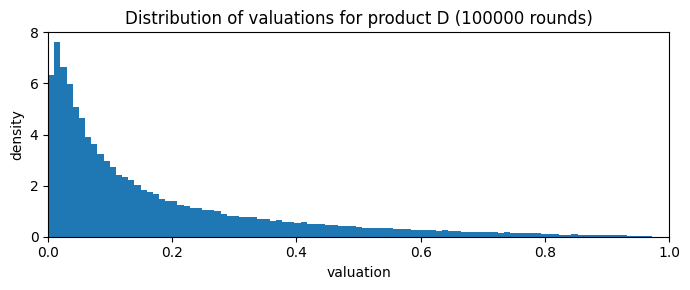

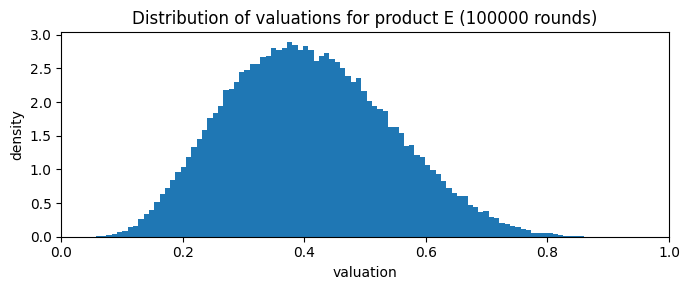

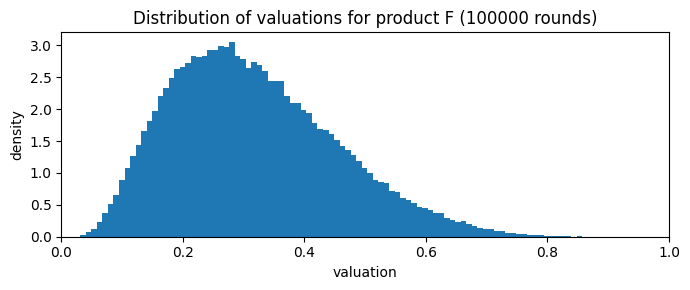

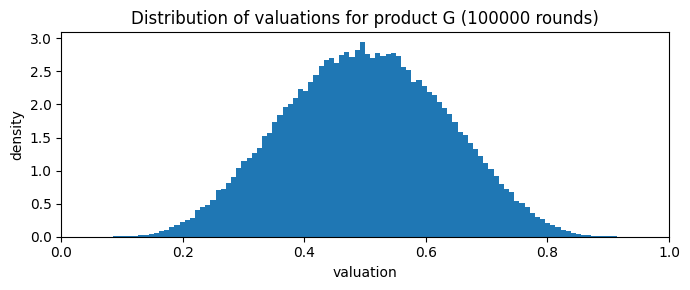

Trial 1:   0%|          | 0/500 [00:00<?, ?it/s]






















Trial 1:   2%|▏         | 11/500 [00:00<00:05, 89.83it/s]







































Trial 1:   4%|▍         | 20/500 [00:00<00:09, 52.52it/s]




















Trial 1:   5%|▌         | 26/500 [00:00<00:10, 47.28it/s]























Trial 1:   6%|▋         | 32/500 [00:00<00:10, 42.63it/s]

























Trial 1:   7%|▋         | 37/500 [00:00<00:14, 31.84it/s]




















Trial 1:   9%|▉         | 46/500 [00:01<00:10, 42.62it/s]






























Trial 1:  10%|█         | 52/500 [00:01<00:11, 40.29it/s]




























Trial 1:  11%|█▏        | 57/500 [00:01<00:13, 33.29it/s]




















Trial 1:  13%|█▎        | 64/500 [00:01<00:10, 39.92it/s]





Trial 1:  14%|█▍        | 69/500 [00:01<00:10, 39.22it/s]






























Trial 1:  15%|█▍        | 74/500 [00:01<00:11, 36.34it/s]



















Trial 1:  16%|█▌        | 78/500

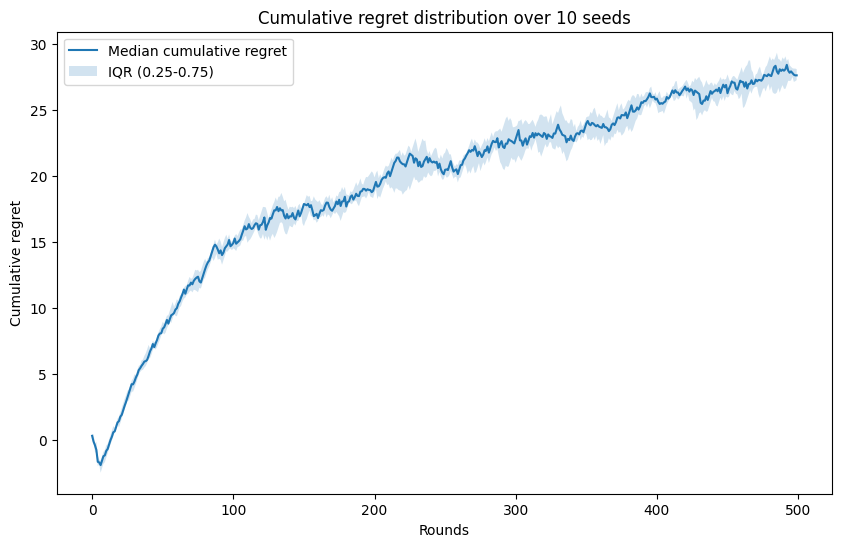

In [ ]:
"""
Experiment: Clustered correlations with low budget (B = 200, T = 500)

Purpose:
- Test the Optimistic Bandit agent under product clusters with positive correlations.
- Limited budget scenario forces careful exploration and price selection.

Setup:
- 7 products divided into three clusters:
    Cluster 1 (A, B, C): correlation 0.7
    Cluster 2 (D, E): correlation 0.5
    Cluster 3 (F, G): correlation 0.3
- Variance for all products: 0.02
- Covariance matrix constructed from cluster correlations and variances.
- Price space discretized into K = 14 values (2 * T^0.33).
- Multiple seeds simulate independent trials for robust statistics.

Procedure:
- Environment samples product valuations using the covariance matrix.
- Agent selects prices each round until budget is exhausted or T rounds.
- Cumulative regret measured against clairvoyant benchmark.
- Aggregate results across seeds to get median and interquartile range (IQR).

Output:
- Plot of median cumulative regret over rounds with IQR shading,
  showing agent performance under correlated clusters with constrained budget.
"""

run_one = False
products = ['A','B','C', 'D', 'E', 'F', 'G']
budget = 200
T = 500
seeds = [23424,3431,65762,842357,2346532,13564,98765,2557,123564,12364]
epsilon = T ** (-0.33)
# The two was chosen empirically
K = 2*int(1 / epsilon)
print(f'Discretizing prices with {K} values')
prices_per_product = np.linspace(0, 1, K)
means = np.array([0.2, 0.5, 0.8, 0.1, 0.4, 0.3, 0.5])
vars = 0.02*np.ones(len(products))
corr = np.eye(len(products))  # start with identity (each product correlated with itself)

# Cluster 1: A, B, C
for i in [0,1,2]:
    for j in [0,1,2]:
        if i != j:
            corr[i,j] = 0.7   # strong positive correlation
# Cluster 2: D, E
corr[3,4] = corr[4,3] = 0.5
# Cluster 3: F, G
corr[5,6] = corr[6,5] = 0.3
# Convert correlation → covariance
D = np.diag(np.sqrt(vars))
covs = D @ corr @ D
print("Covariance matrix:\n", covs)
# Just to plot distribution
env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, plot_distribution=True)

if run_one:
    cum_regret, actions = run_single_trial(0, products, prices_per_product, budget, T, means, covs, seed=3, extensive_plots=False)
    median_regret = cum_regret
else:
    all_regrets, actions = run_all_trials_parallel(seeds, products, prices_per_product, budget, T, means, covs, n_jobs=-1)
    all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
    lq_regret, median_regret, hq_regret = np.quantile(all_regrets, q=[0.25, 0.5, 0.75], axis=0)

plt.figure(figsize=(10,6))
plt.plot(median_regret, label='Median cumulative regret')
if not run_one:
    plt.fill_between(range(T), lq_regret, hq_regret, alpha=0.2, label='IQR (0.25-0.75)')
plt.xlabel('Rounds')
plt.ylabel('Cumulative regret')
plt.title(f'Cumulative regret distribution over {len(seeds)} seeds')
plt.legend()
plt.show()

And also in this last case, we achieve **sublinear** regret. So,we can conclude that, given our specific instance of a multiple products environment with joint correlated valuations, the Agent is able to achieve **sublinear** cumulative regret in all the trials, proving that is a consistent and effective learning Agent in this scenario.